In [4]:
# import pyBigWig
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from pyliftover import LiftOver
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
# from pybedtools import BedTool
from collections import defaultdict
import pysam
from sklearn.metrics import roc_curve, auc
from scipy.stats import spearmanr, pearsonr
from collections import defaultdict

### Make sure down download dataset_14-lmnb1_4-cpg.h5 and probe_first_full_run.h5 to this folder before running this notebook
https://drive.google.com/drive/folders/1ZA8nlNrMW8K0ATsqDp4TM_5mEDTlK9Gs?usp=sharing

In [5]:
# These are the necessary files to run the rest of the notebook, make sure you have them all in the folder

sequences_bed_path = 'sequences.bed'

shah_tracks = ['GSM5669183_CardiacMyocytes_rep1_LB1.bigwig',
               'GSM5669188_APS_rep1_LB1.bigwig',
               'GSM5669193_BorderEctoderm_rep1_LB1.bigwig',
               'GSM5669198_D5Midbrain_rep1_LB1.bigwig',
               'GSM5669203_DefEctoderm_rep1_LB1.bigwig',
               'GSM5669209_EarlySomite_rep1_LB1.bigwig',
               'GSM5669214_EndoProgenitor_rep1_LB1.bigwig',
               'GSM5669220_Epicardium_rep1_LB1.bigwig',
               'GSM5669226_H9ESC_rep1_LB1.bigwig',
               'GSM5669232_Liver_rep1_LB1.bigwig',
               'GSM5669238_MidHindgut_rep1_LB1.bigwig',
               'GSM5669244_ParaxMesoderm_rep1_LB1.bigwig']
dimelo_tracks = ['HEK293_LMNB1','GM12878_LMNB1','HEK293_CpG_methylation','HEK293_CpG_motifs','GM12878_CpG_methylation','GM12878_CpG_motifs']

all_tracks = [shah_track[0:-16] for shah_track in shah_tracks] + dimelo_tracks

# /clusterfs/nilah/oberon/datasets/cs282a/
dataset_filepath = '/clusterfs/nilah/oberon/datasets/cs282a/dataset_14-lmnb1_4-cpg.h5'

cm_LAD_tabix_str = 'GSM5669183_CardiacMyocytes_LADs.sorted.bed.gz'
fl_LAD_tabix_str = '/clusterfs/nilah/oberon/datasets/lamina_association_shah/GSM5669232_Liver_LADs.sorted.bed.gz'

# /clusterfs/nilah/oberon/datasets/cs282a/inference/
linear_probe_inference = '/clusterfs/nilah/oberon/datasets/cs282a/inference/probe_first_full_run.h5'
multilayer_inference = 'mlp_model_20231128_063541_2.h5'
maxpool_inference = 'maxpool_model_20231128_072156_3.h5'
transformer_inference = 'transformer_model_20231128_080512_7.h5'

In [6]:
for track_index,track_name in enumerate(all_tracks):
    print(track_name)

GSM5669183_CardiacMyocytes
GSM5669188_APS
GSM5669193_BorderEctoderm
GSM5669198_D5Midbrain
GSM5669203_DefEctoderm
GSM5669209_EarlySomite
GSM5669214_EndoProgenitor
GSM5669220_Epicardium
GSM5669226_H9ESC
GSM5669232_Liver
GSM5669238_MidHindgut
GSM5669244_ParaxMesoderm
HEK293_LMNB1
GM12878_LMNB1
HEK293_CpG_methylation
HEK293_CpG_motifs
GM12878_CpG_methylation
GM12878_CpG_motifs


In [7]:
h5_files_dict = {
    'linear-probe':(linear_probe_inference,'128bp_bins'),
    'conv-perceptron':(multilayer_inference,'single_bin'),
    'maxpool-perceptron':(maxpool_inference,'single_bin'),
    'transformer':(transformer_inference,'single_bin'),
}

In [8]:
# These are approximate chromosome lengths from the hg38 reference genome
chrom_lengths = {    
    'chr1':249000000,
    'chr2':243000000,
    'chr3':198000000,
    'chr4':191000000,
    'chr5':182000000,
    'chr6':171000000,
    'chr7':160000000,
    'chr8':146000000,
    'chr9':140000000,
    'chr10':135000000,
    'chr11':135000000,
    'chr12':133000000,
    'chr13':113500000,
    'chr14':107000000,
    'chr15':102000000,
    'chr16':90000000,
    'chr17':84000000,
    'chr18':80000000,
    'chr19':59000000,
    'chr20':66000000,
    'chr21':48000000,
    'chr22':51000000,
    'chrX':155000000,
}

In [11]:
cm_LADs_tabix = pysam.TabixFile(cm_LAD_tabix_str)
fl_LADs_tabix = pysam.TabixFile(fl_LAD_tabix_str)
# If you have memory limitations, you may prefer to run a subset of chromosomes. 
# chr14 (element 13 of the list) is almost entirely test set so that is a good choice for assessing
plot_chroms = list(chrom_lengths.keys())[13:14]
chrom_results = {}
for plot_chrom in tqdm(plot_chroms):
    plot_startco = 0
    plot_endco = chrom_lengths[plot_chrom]
    plot_xcoord = np.arange(start=plot_startco,stop=plot_endco,step=128)
    length = len(plot_xcoord)
    h5py_files = {}
    default_array = np.full((length, 18), np.nan,dtype=float)
    def default_factory():
        return default_array.copy()
    output_arrays = defaultdict(default_factory)
    plot_array_low_res = np.full((length, 18), np.nan)
    plot_array_high_res = np.full((length, 18), np.nan)
    cm_lads_array = np.zeros(length)
    fl_lads_array = np.zeros(length)
    test_train_split_array = np.zeros(length)


    buffer_at_ends = 8192
    seqbedlen = 38171
    test_train_split_array
    with open(sequences_bed_path,'r') as bed_file, h5py.File(dataset_filepath,'r') as f:
        for key, file_path in h5_files_dict.items():
            h5py_files[key]=h5py.File(file_path[0],'r')

        for index,bed_line in tqdm(enumerate(bed_file),total=seqbedlen,desc=f'reading labels and predictions for {plot_chrom}'):
            location_fields = bed_line.split('\t')
            chrom = str(location_fields[0])
            start = int(location_fields[1])+buffer_at_ends
            end = int(location_fields[2])-buffer_at_ends  
            set_int = 0
            if location_fields[3].strip()=='train':
                set_int = 1
            elif location_fields[3].strip()=='valid':
                set_int = 2
            elif location_fields[3].strip()=='test':
                set_int = 3

            cm_lad_type = 0
            fl_lad_type = 0
            for interval in cm_LADs_tabix.fetch(plot_chrom,start,end):
                fields = interval.split('\t')
                cm_lad_type = max(int(fields[3][1]),cm_lad_type)
                
            for interval in fl_LADs_tabix.fetch(plot_chrom,start,end):
                fields = interval.split('\t')
                fl_lad_type = max(int(fields[3][1]),fl_lad_type)

            if end>plot_startco and start<plot_endco and chrom==plot_chrom:
                if start>plot_startco and end<plot_endco:
                    for key,file_details in h5_files_dict.items():
                        output_arrays[key][(start-plot_startco)//128:(end-plot_startco)//128,:] = h5py_files[key][file_details[1]][index,:,:]
                    plot_array_low_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = f['single_bin'][index,:,:]
                    plot_array_high_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = f['128bp_bins'][index,:,:]
                    cm_lads_array[(start-plot_startco)//128:(end-plot_startco)//128] = cm_lad_type
                    fl_lads_array[(start-plot_startco)//128:(end-plot_startco)//128] = fl_lad_type
                    test_train_split_array[(start-plot_startco)//128:(end-plot_startco)//128] = set_int
    chrom_results[plot_chrom] = (
        plot_xcoord,
        plot_array_low_res,
        plot_array_high_res,
        output_arrays,
        cm_lads_array,
        fl_lads_array,
        test_train_split_array,
    )

  0%|          | 0/1 [00:00<?, ?it/s]

reading labels and predictions for chr14:   0%|          | 0/38171 [00:00<?, ?it/s]

In [12]:
# This cell simply spits out the composition of each chromosome in terms of test/train/validation split, as 
# well as unindexed portions (mostly repetitive regions that are left out of training, e.g. centromeres)
sets_strings_dict = {}
for plot_chrom in plot_chroms:
    (
        plot_xcoord,
        plot_array_low_res,
        plot_array_high_res,
        output_arrays,
        cm_lads_array,
        fl_lads_array,
        test_train_split_array,
    ) = chrom_results[plot_chrom]
    unindexed_num = np.sum(test_train_split_array==0)
    train_num = np.sum(test_train_split_array==1)
    valid_num = np.sum(test_train_split_array==2)
    test_num = np.sum(test_train_split_array==3)
    total_num = train_num + valid_num + test_num + unindexed_num
    sets_string = f'{100*train_num/total_num:.2f}% training set, {100*valid_num/total_num:.2f}% validation set, {100*test_num/total_num:.2f}% test set, {100*unindexed_num/total_num:.2f}% unindexed'
    print(plot_chrom,sets_string)
    sets_strings_dict[plot_chrom] = sets_string

chr14 0.00% training set, 0.00% validation set, 80.71% test set, 19.29% unindexed


In [13]:
set_dict = {
    'train':1,
    'valid':2,
    'test':3,
}
plot_arrays_low_res_list = []
plot_arrays_high_res_list = []
output_arrays_lists_dict = defaultdict(list)
cm_lads_arrays_list = []
fl_lads_arrays_list = []
test_train_split_arrays_list = []
for plot_chrom in plot_chroms:
    (
    plot_xcoord,
    plot_array_low_res,
    plot_array_high_res,
    output_arrays,
    cm_lads_array,
    fl_lads_array,
    test_train_split_array,
    ) = chrom_results[plot_chrom]
    plot_arrays_low_res_list.append(plot_array_low_res)
    plot_arrays_high_res_list.append(plot_array_high_res)
    for key,value in output_arrays.items():
        output_arrays_lists_dict[key].append(value)
    cm_lads_arrays_list.append(cm_lads_array)
    fl_lads_arrays_list.append(fl_lads_array)
    test_train_split_arrays_list.append(test_train_split_array)
print('concatenating chromosome arrays')
plot_array_low_res_concat = np.concatenate(plot_arrays_low_res_list,axis=0)
plot_array_high_res_concat = np.concatenate(plot_arrays_high_res_list,axis=0)
output_arrays_concat = {}
for key,value in output_arrays_lists_dict.items():
    output_arrays_concat[key] = np.concatenate(value,axis=0)
cm_lads_array_concat = np.concatenate(cm_lads_arrays_list,axis=0)
fl_lads_array_concat = np.concatenate(fl_lads_arrays_list,axis=0)
test_train_split_array_concat = np.concatenate(test_train_split_arrays_list,axis=0)

concatenating chromosome arrays


skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


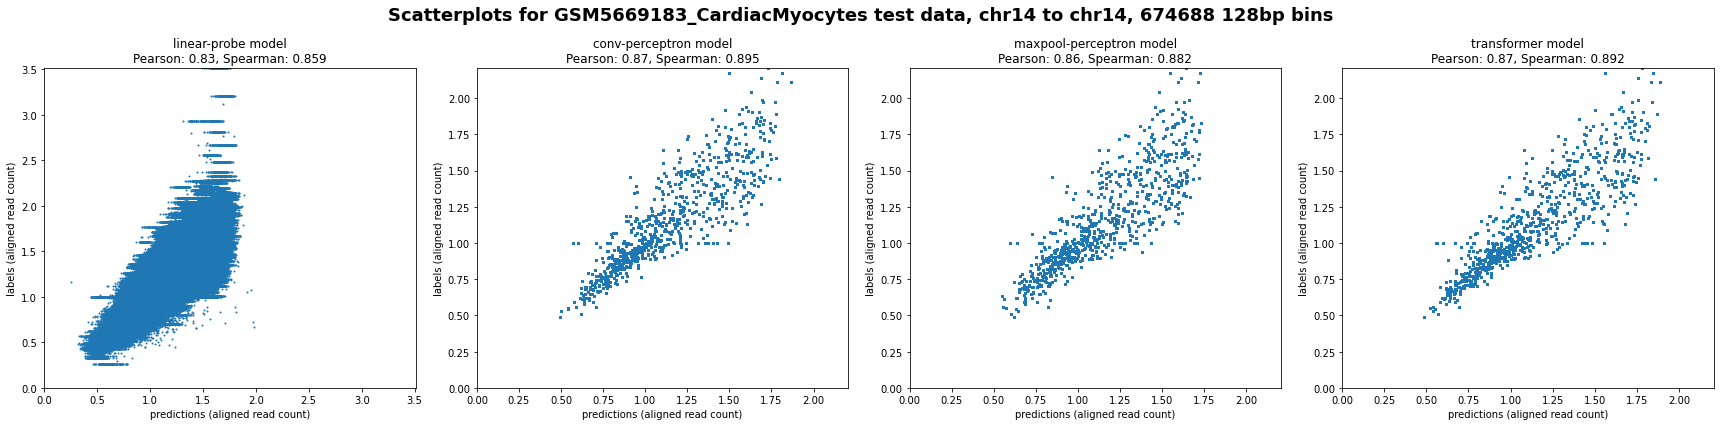

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


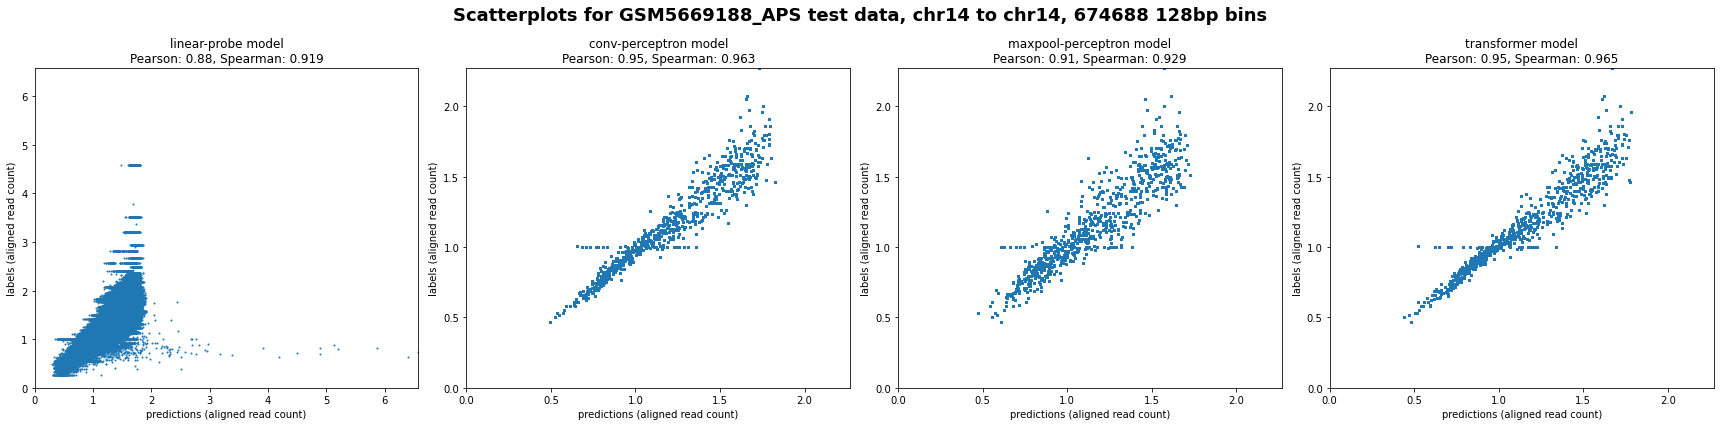

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


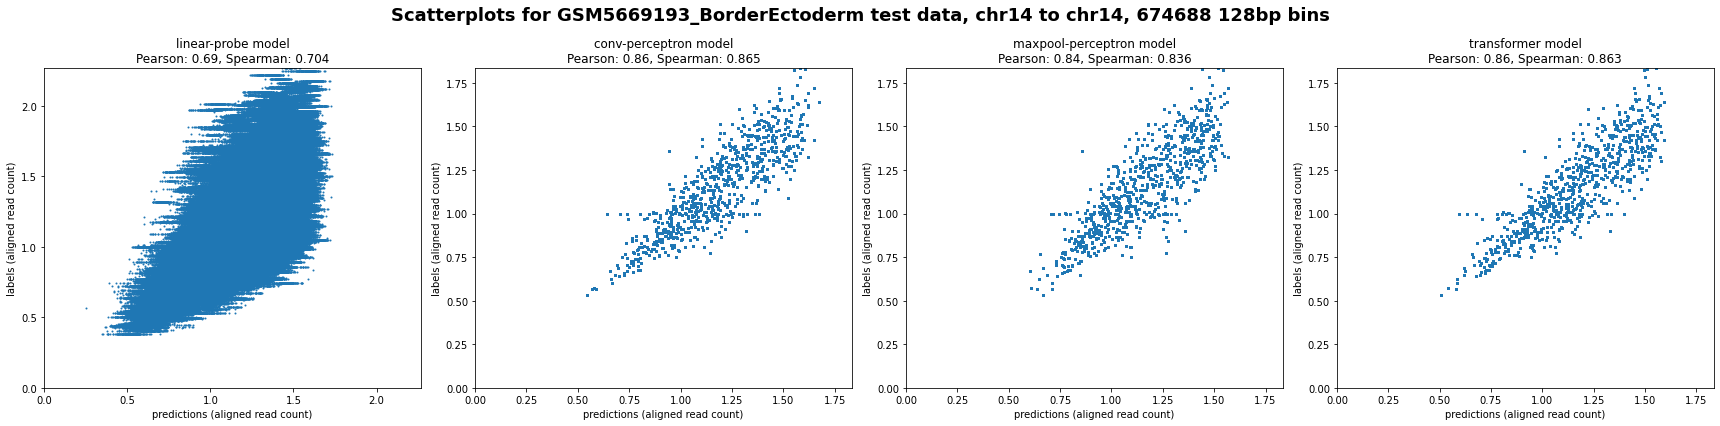

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


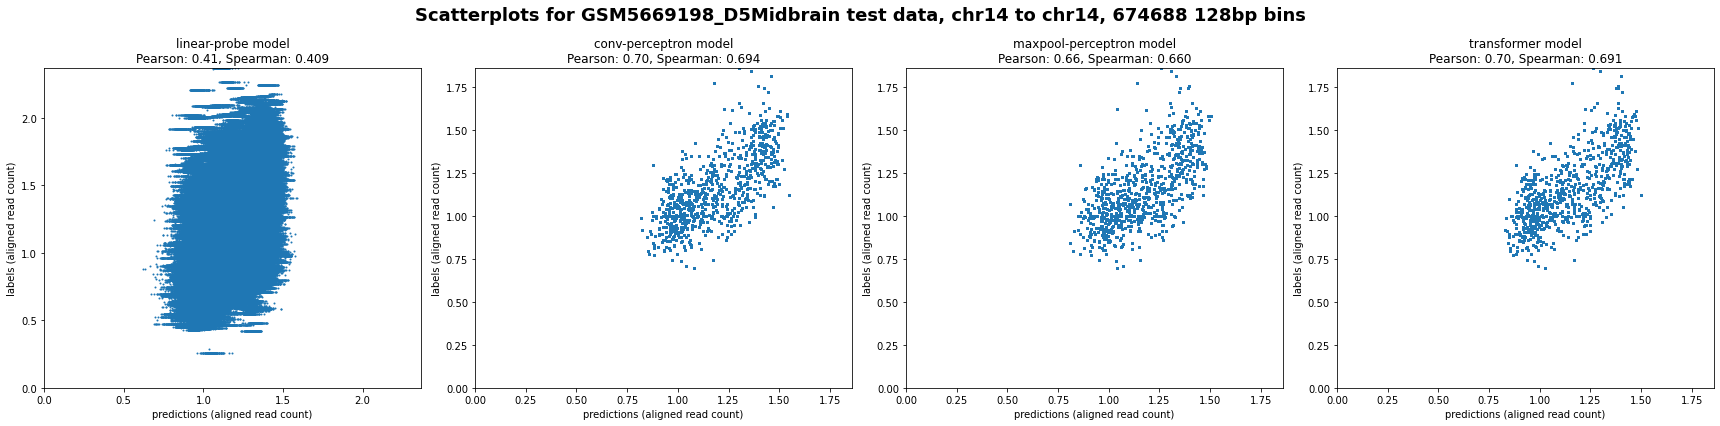

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


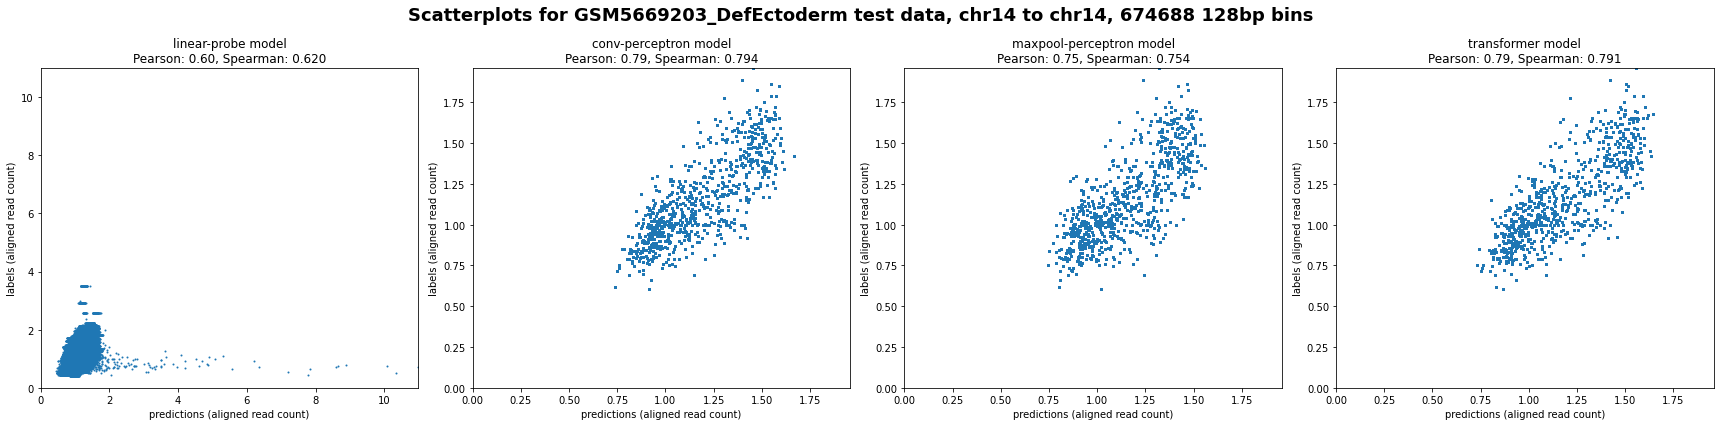

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


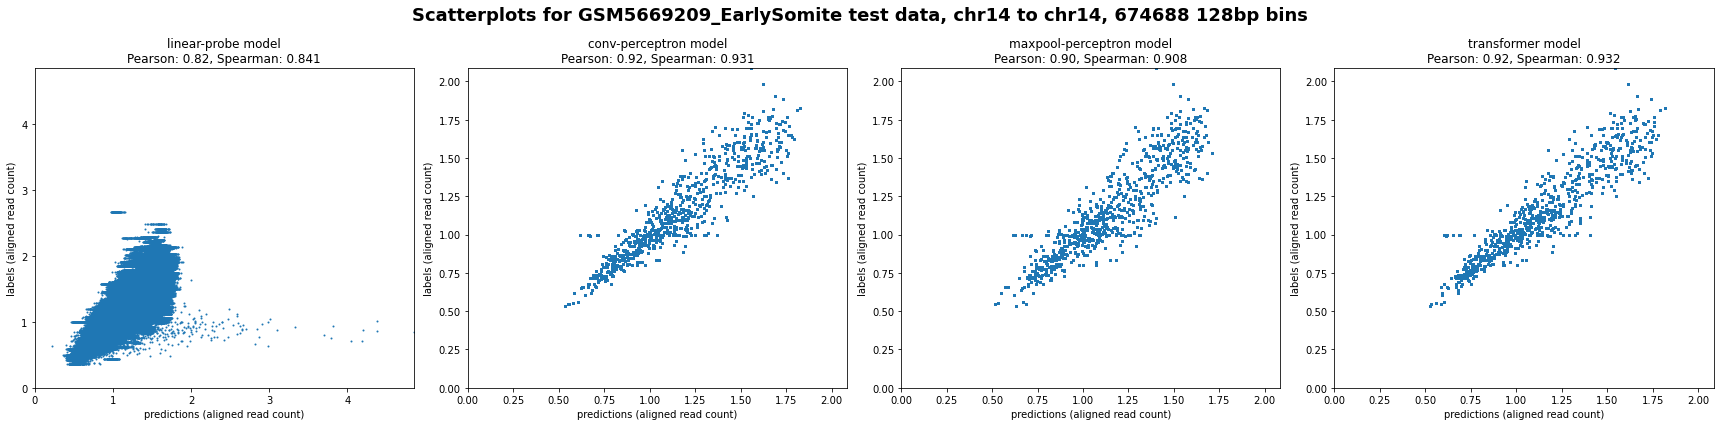

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


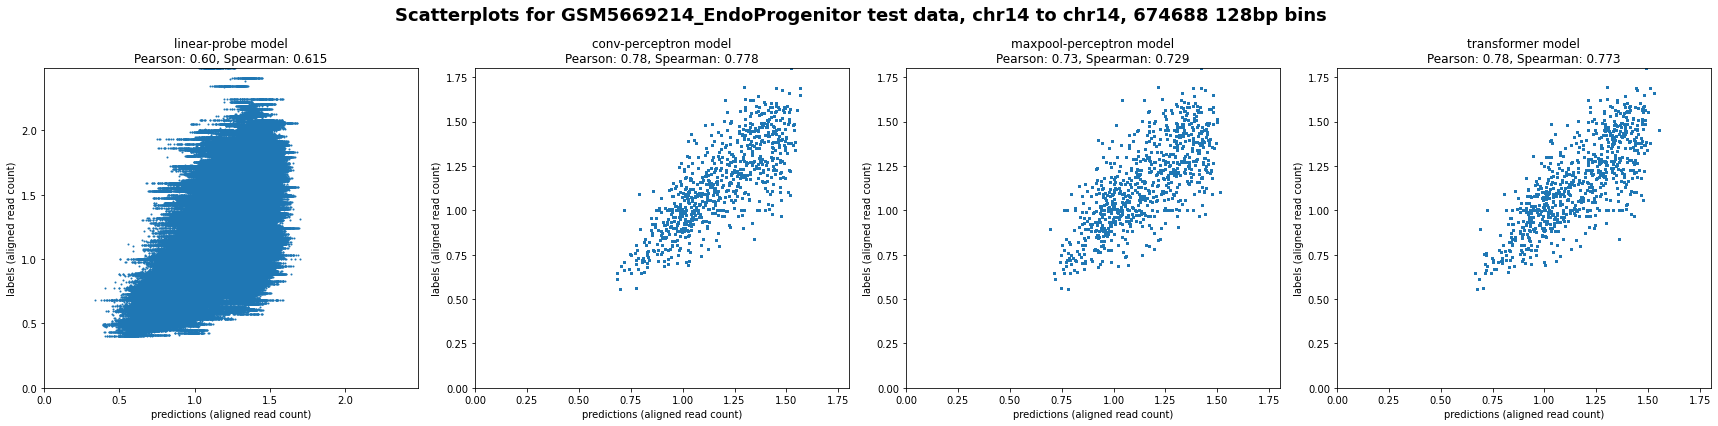

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


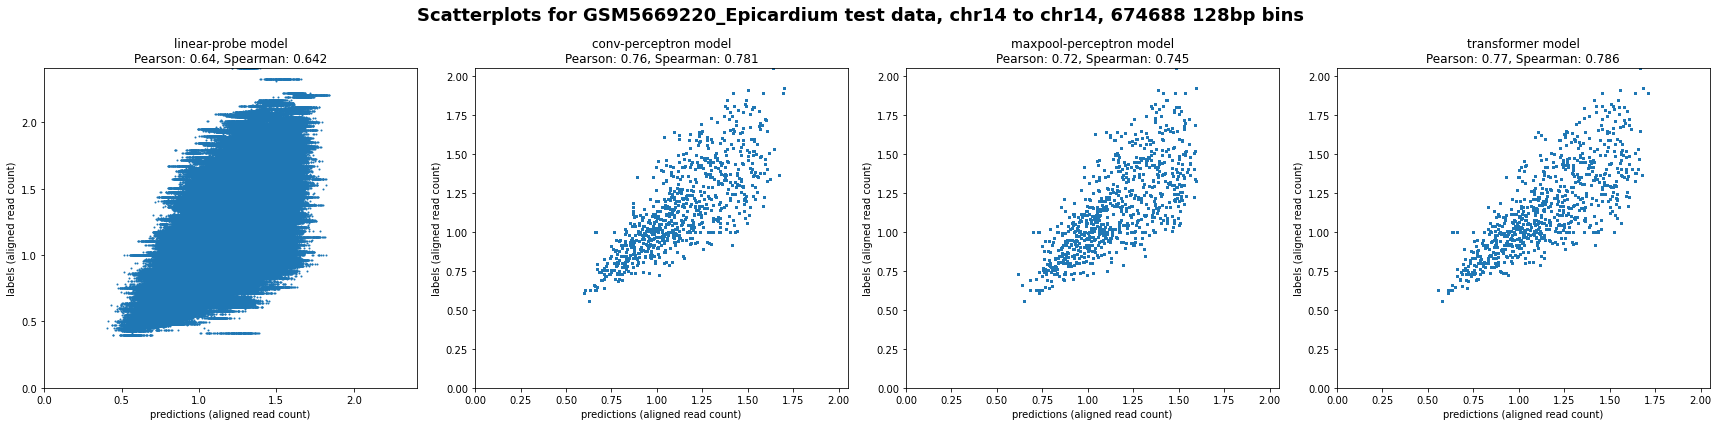

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


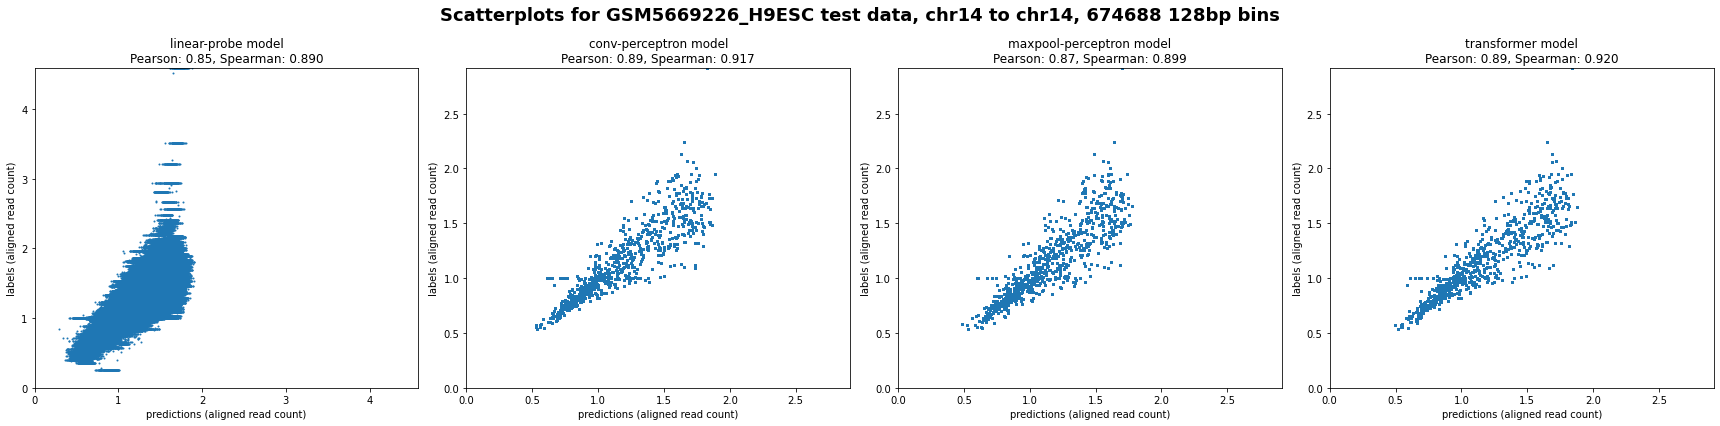

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


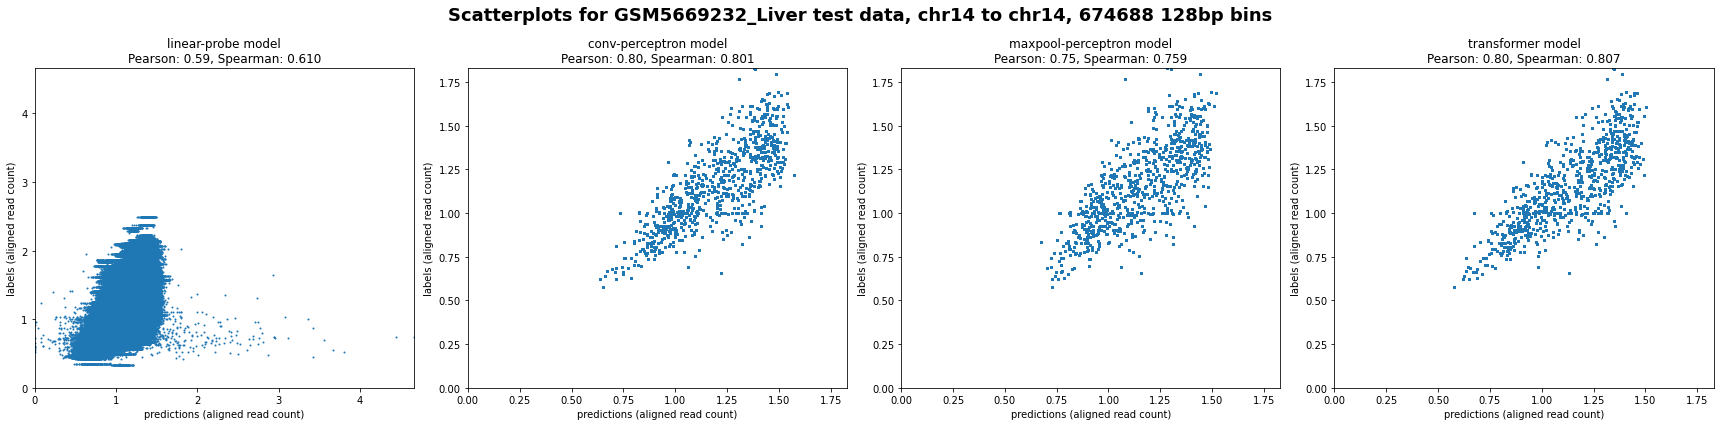

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


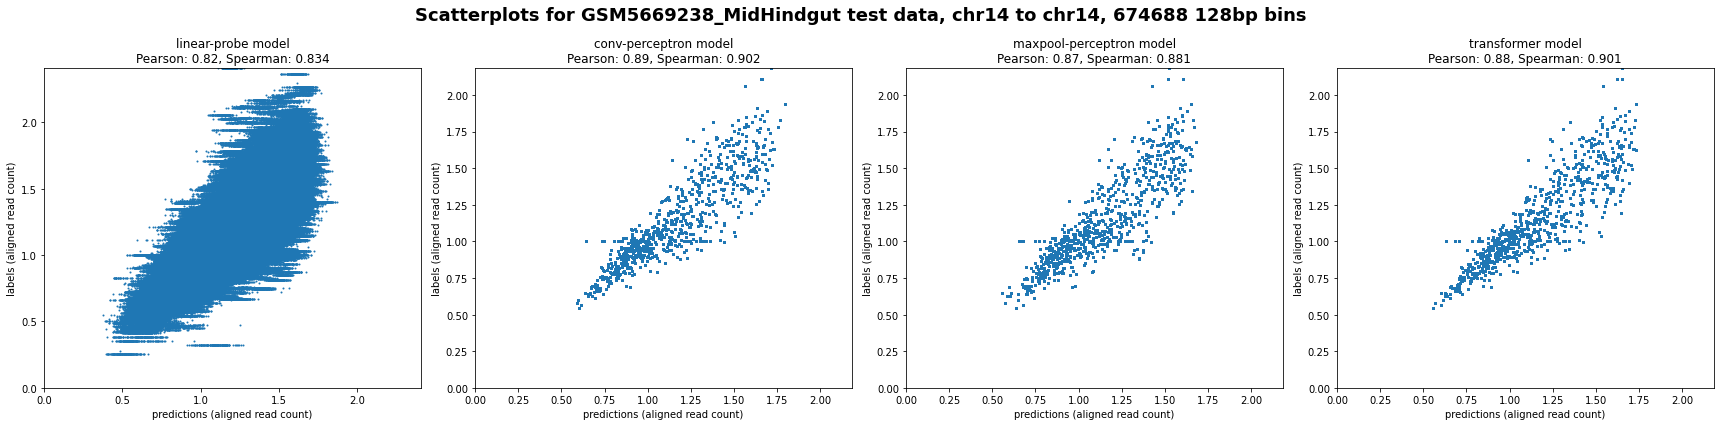

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


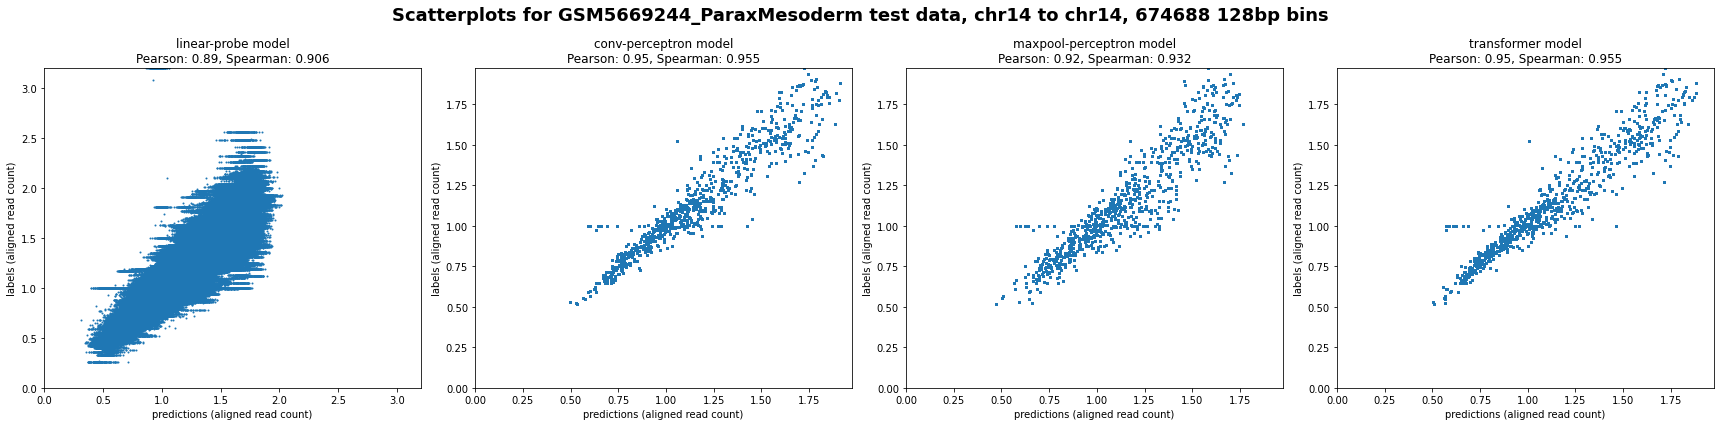

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


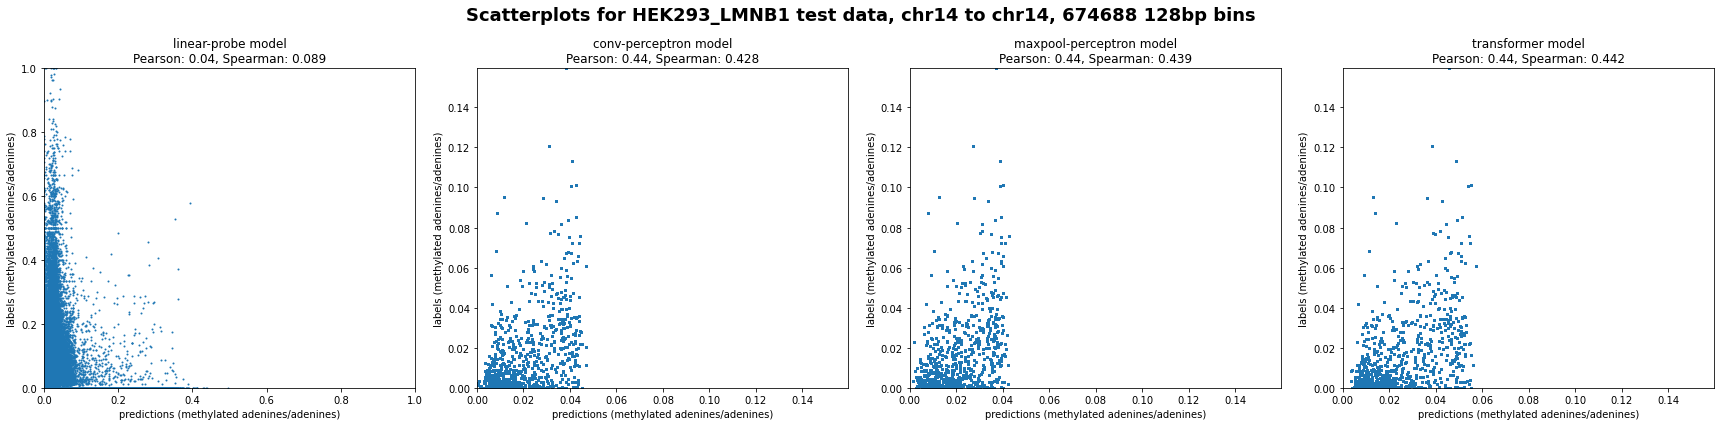

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


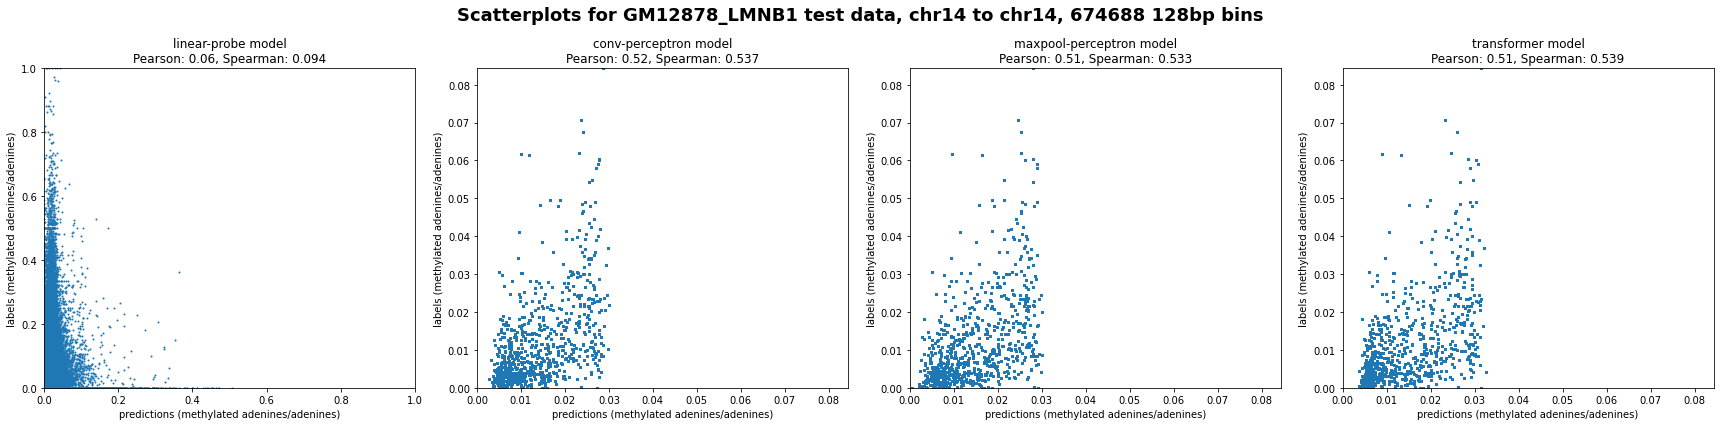

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


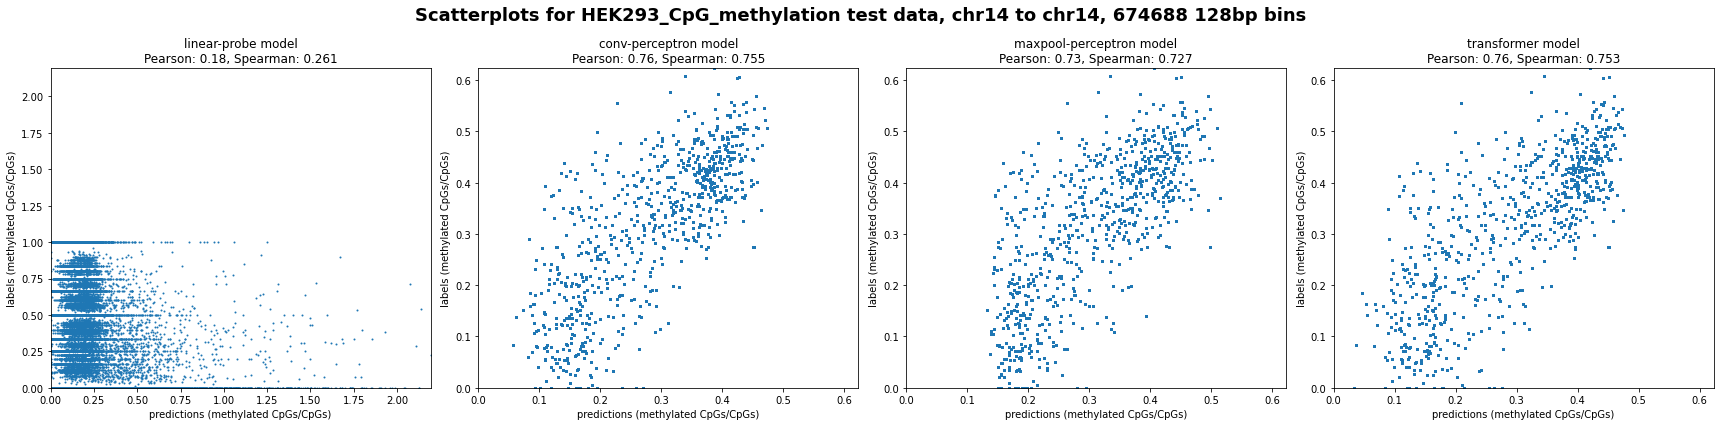

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


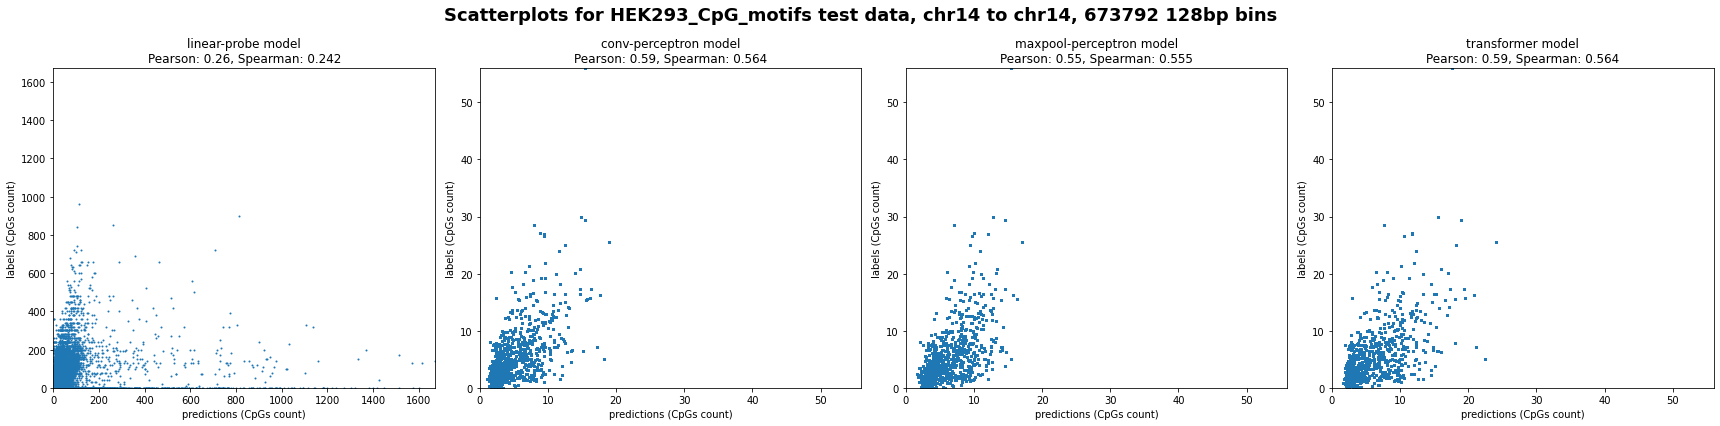

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


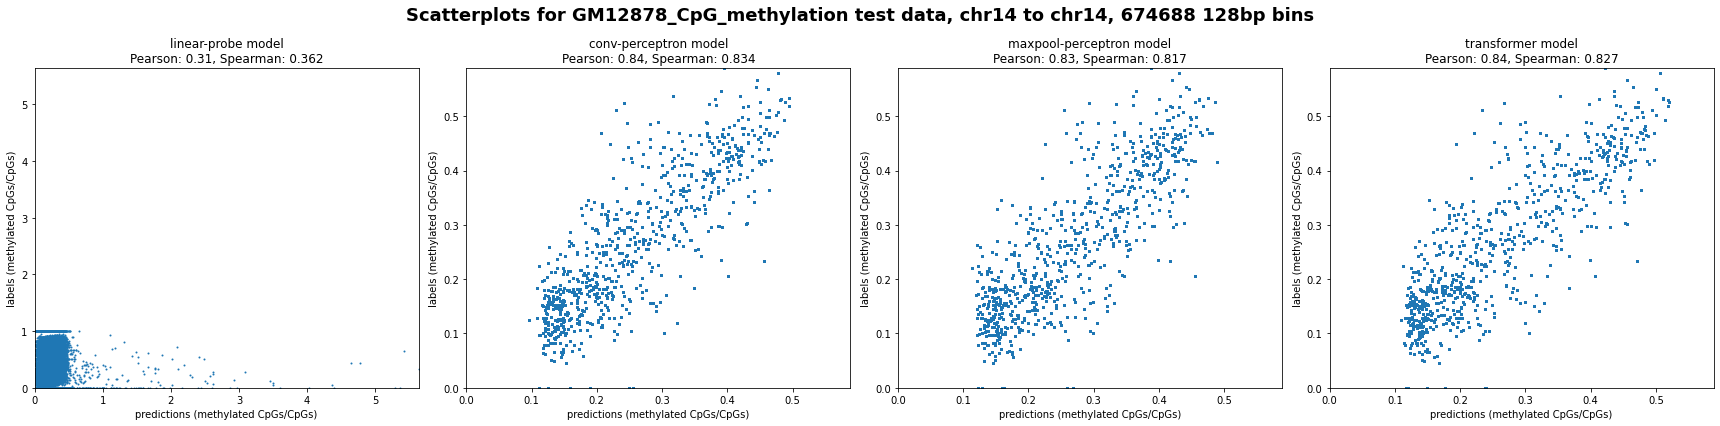

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


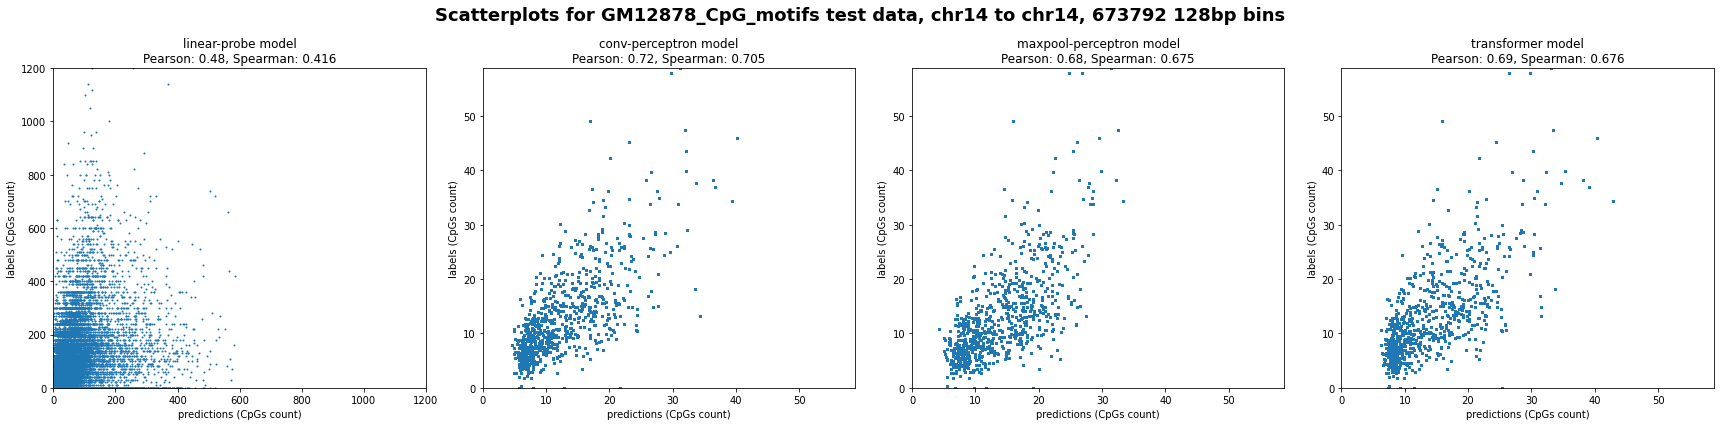

In [16]:
scaling_by_track = [1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/500,1/500,1/500,1,1/500,1]
data_label_by_track = ['(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(methylated adenines/adenines)',
                       '(methylated adenines/adenines)',
                       '(methylated CpGs/CpGs)',
                       '(CpGs count)',
                       '(methylated CpGs/CpGs)',
                       '(CpGs count)'
                      ]
for i,track_name in enumerate(all_tracks):
    for subset_name,subset_label  in set_dict.items():
        if np.sum(test_train_split_array_concat==subset_label)<2:
            print('skipping',subset_name,'too few entries from',plot_chroms)
            continue
    
        fig1, axs1 = plt.subplots(1,4,figsize=(24,6))


        for idx,(key,output_array) in enumerate(output_arrays_concat.items()):
            # Screen out nan values from the labels array
            scaling = scaling_by_track[i]
            axlabel = data_label_by_track[i]
            nas_i = np.logical_or(np.isnan(output_array[:,i]),np.isnan(plot_array_low_res_concat[:,i]))
            subset_mask = (test_train_split_array_concat==subset_label)
            regions_count = np.sum(subset_mask & ~nas_i)
            fig1.suptitle(f'Scatterplots for {track_name} {subset_name} data, {plot_chroms[0]} to {plot_chroms[-1]}, {regions_count} 128bp bins',fontweight='bold',size=18)
            if h5_files_dict[key][1]=='128bp_bins':
                pearson, _ = pearsonr((output_array[:,i])[subset_mask&~nas_i],(plot_array_high_res_concat[:,i])[subset_mask&~nas_i])
                spearman, _ = spearmanr((output_array[:,i])[subset_mask&~nas_i],(plot_array_high_res_concat[:,i])[subset_mask&~nas_i])
                upper_lim = np.maximum(np.max((output_array[:,i])[subset_mask&~nas_i]),np.max((plot_array_high_res_concat[:,i])[subset_mask&~nas_i]))
                axs1[idx].scatter((output_array[:,i])[subset_mask]*scaling,(plot_array_high_res_concat[:,i])[subset_mask]*scaling,s=1)
                axs1[idx].set_xlim([0,upper_lim*scaling])
                axs1[idx].set_ylim([0,upper_lim*scaling])
                axs1[idx].set_xlabel(f'predictions {axlabel}')
                axs1[idx].set_ylabel(f'labels {axlabel}')
                axs1[idx].set_title(f'{key} model\nPearson: {pearson:.2f}, Spearman: {spearman:.3f}')
            elif h5_files_dict[key][1]=='single_bin':
                pearson, _ = pearsonr((output_array[:,i])[subset_mask&~nas_i],(plot_array_low_res_concat[:,i])[subset_mask&~nas_i])
                spearman, _ = spearmanr((output_array[:,i])[subset_mask&~nas_i],(plot_array_low_res_concat[:,i])[subset_mask&~nas_i])
                upper_lim = np.maximum(np.max((output_array[:,i])[subset_mask&~nas_i]),np.max((plot_array_low_res_concat[:,i])[subset_mask&~nas_i]))
                axs1[idx].scatter((output_array[:,i])[subset_mask]*scaling,(plot_array_low_res_concat[:,i])[subset_mask]*scaling,s=1)
                axs1[idx].set_xlim([0,upper_lim*scaling])
                axs1[idx].set_ylim([0,upper_lim*scaling])
                axs1[idx].set_xlabel(f'predictions {axlabel}')
                axs1[idx].set_ylabel(f'labels {axlabel}')
                axs1[idx].set_title(f'{key} model\nPearson: {pearson:.2f}, Spearman: {spearman:.3f}')
#             print(f'{track_name}\t{key}\tpearson: {pearson}\tspearman: {spearman}')

        plt.tight_layout()
        plt.show()

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


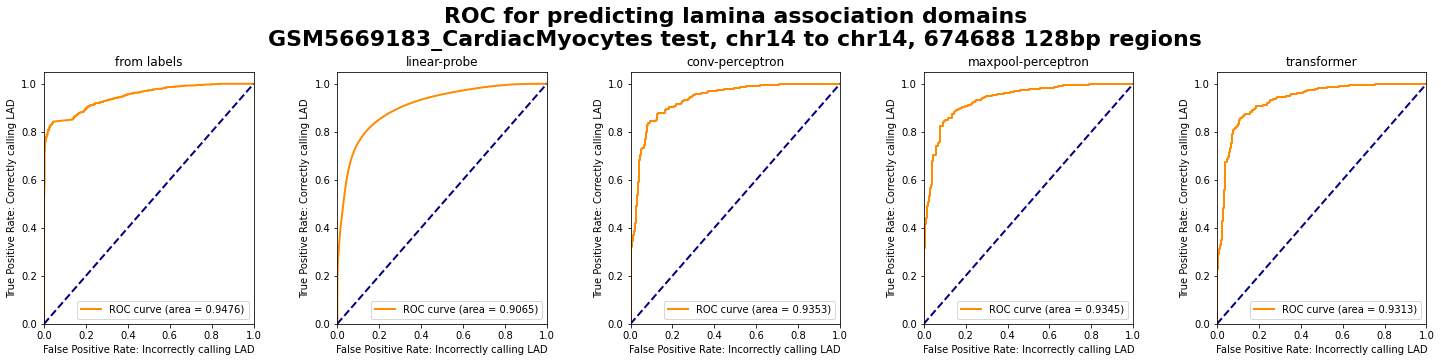

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


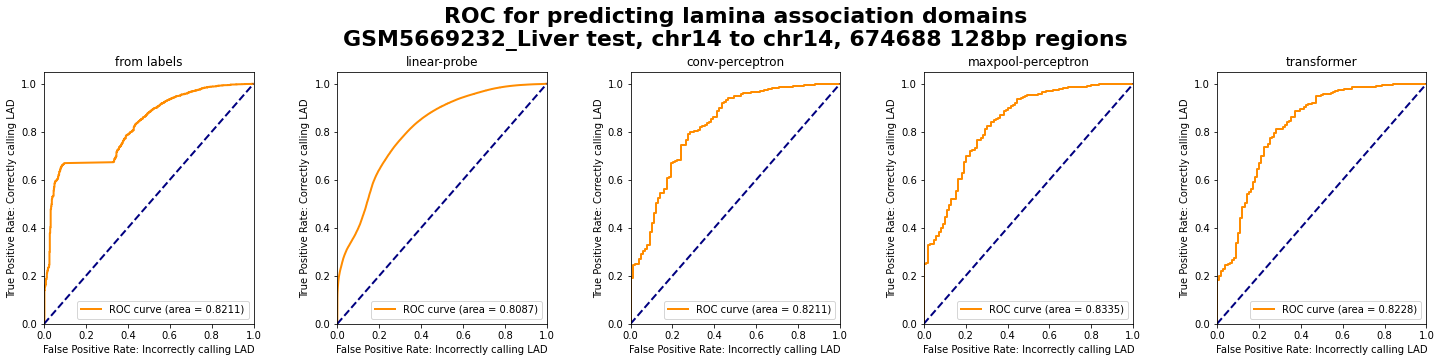

In [17]:
for i,lads_array in [(0,cm_lads_array_concat),(9,fl_lads_array_concat)]:
    for subset_name,subset_label  in set_dict.items():
        
        if np.sum(test_train_split_array_concat==subset_label)<2:
            print('skipping',subset_name,'too few entries from',plot_chroms)
            continue
        nas_i = np.isnan(plot_array_low_res_concat[:,i])
        subset_mask = (test_train_split_array_concat==subset_label)
        regions_count = np.sum(subset_mask & ~nas_i)

        fig1, axs1 = plt.subplots(1,5,figsize=(24,5))
        fig1.suptitle(f'ROC for predicting lamina association domains\n{all_tracks[i]} {subset_name}, {plot_chroms[0]} to {plot_chroms[-1]}, {regions_count} 128bp regions',fontweight='bold',size=22)
        # Calculate ROC curve from labels
        fpr, tpr, thresholds = roc_curve(lads_array[subset_mask]>0,np.nan_to_num(plot_array_high_res_concat[subset_mask,0]))
        roc_auc = auc(fpr, tpr)
        axs1[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = %0.4f)' % roc_auc)
        axs1[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs1[0].set_xlim([0.0, 1.0])
        axs1[0].set_ylim([0.0, 1.05])
        axs1[0].set_xlabel('False Positive Rate: Incorrectly calling LAD')
        axs1[0].set_ylabel('True Positive Rate: Correctly calling LAD')
        axs1[0].set_title(f'from labels')    
        axs1[0].legend(loc="lower right")

        for indx,(key,output_array) in enumerate(output_arrays_concat.items()):
            fpr, tpr, thresholds = roc_curve(lads_array[subset_mask]>0,np.nan_to_num(output_array[subset_mask,0]))
            roc_auc = auc(fpr, tpr)

            axs1[indx+1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
            axs1[indx+1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            axs1[indx+1].set_xlim([0.0, 1.0])
            axs1[indx+1].set_ylim([0.0, 1.05])
            axs1[indx+1].set_xlabel('False Positive Rate: Incorrectly calling LAD')
            axs1[indx+1].set_ylabel('True Positive Rate: Correctly calling LAD')
            axs1[indx+1].set_title(f'{key}')
            axs1[indx+1].legend(loc="lower right")
        fig1.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, hspace=0.5, wspace=0.4)
        plt.show()

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


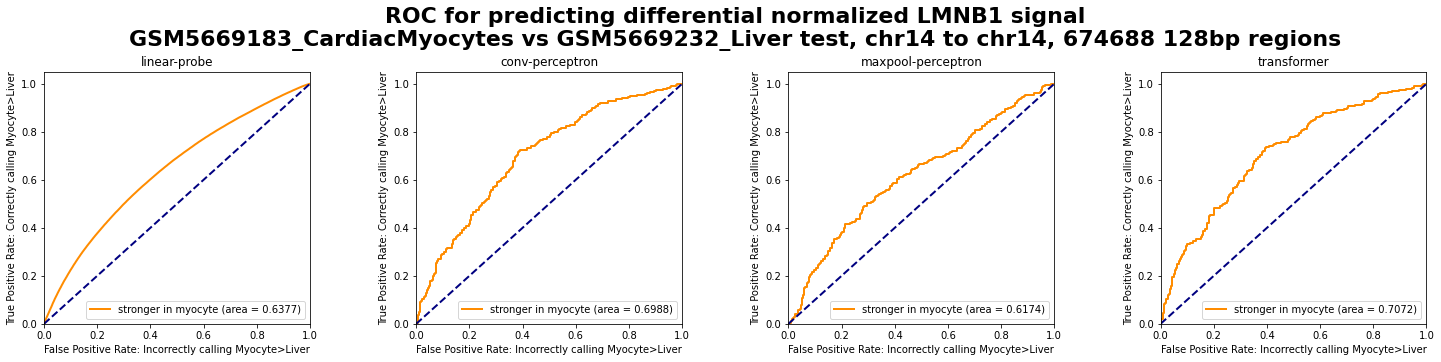

In [18]:
for subset_name,subset_label  in set_dict.items():
    if np.sum(test_train_split_array_concat==subset_label)<2:
        print('skipping',subset_name,'too few entries from',plot_chroms)
        continue
    nas_i = np.isnan(plot_array_low_res_concat[:,0])
    subset_mask = (test_train_split_array_concat==subset_label)
    regions_count = np.sum(subset_mask & ~nas_i)
    fig1, axs1 = plt.subplots(1,4,figsize=(24,5))
    fig1.suptitle(f'ROC for predicting differential normalized LMNB1 signal\n{all_tracks[0]} vs {all_tracks[9]} {subset_name}, {plot_chroms[0]} to {plot_chroms[-1]}, {regions_count} 128bp regions',fontweight='bold',size=22)
    mean_cm = np.nanmean(plot_array_low_res_concat[:,0])
    std_cm = np.nanstd(plot_array_low_res_concat[:,0])
    mean_fl = np.nanmean(plot_array_low_res_concat[:,9])
    std_fl = np.nanstd(plot_array_low_res_concat[:,9])

    meas_differences = ((plot_array_low_res_concat[:,9]-mean_fl)/std_fl-(plot_array_low_res_concat[:,0]-mean_cm)/std_cm)
    
    for indx,(key,output_array) in enumerate(output_arrays_concat.items()):
        pred_differences = ((output_array[:,9]-mean_fl)/std_fl-(output_array[:,0]-mean_cm)/std_cm)
        fpr1, tpr1, thresholds1 = roc_curve(np.nan_to_num(meas_differences>0)[subset_mask],np.nan_to_num(pred_differences[subset_mask]))
        roc_auc1 = auc(fpr1, tpr1)
        axs1[indx].plot(fpr1, tpr1, color='darkorange', lw=2, label=f'stronger in myocyte (area = %0.4f)' % roc_auc1)
        axs1[indx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs1[indx].set_xlim([0.0, 1.0])
        axs1[indx].set_ylim([0.0, 1.05])
        axs1[indx].set_xlabel('False Positive Rate: Incorrectly calling Myocyte>Liver')
        axs1[indx].set_ylabel('True Positive Rate: Correctly calling Myocyte>Liver')
        axs1[indx].set_title(f'{key}')    
        axs1[indx].legend(loc="lower right")   
    fig1.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, hspace=0.5, wspace=0.4)
    plt.show()

skipping train too few entries from ['chr14']
skipping valid too few entries from ['chr14']


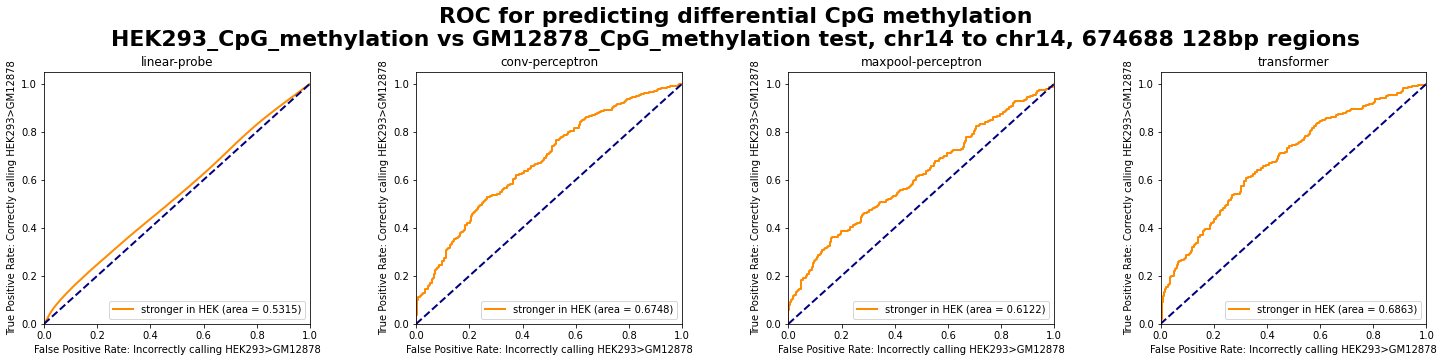

In [19]:
for subset_name,subset_label  in set_dict.items():
    if np.sum(test_train_split_array_concat==subset_label)<2:
        print('skipping',subset_name,'too few entries from',plot_chroms)
        continue
    nas_i = np.isnan(plot_array_low_res_concat[:,0])
    subset_mask = (test_train_split_array_concat==subset_label)
    regions_count = np.sum(subset_mask & ~nas_i)
    fig1, axs1 = plt.subplots(1,4,figsize=(24,5))
    fig1.suptitle(f'ROC for predicting differential CpG methylation\n{all_tracks[14]} vs {all_tracks[16]} {subset_name}, {plot_chroms[0]} to {plot_chroms[-1]}, {regions_count} 128bp regions',fontweight='bold',size=22)

    meas_differences = plot_array_low_res_concat[:,14]-plot_array_low_res_concat[:,16]
    
    for indx,(key,output_array) in enumerate(output_arrays_concat.items()):
        pred_differences = output_array[:,14]-output_array[:,16]
        fpr1, tpr1, thresholds1 = roc_curve(np.nan_to_num(meas_differences>0)[subset_mask],np.nan_to_num(pred_differences[subset_mask]))
        roc_auc1 = auc(fpr1, tpr1)
        axs1[indx].plot(fpr1, tpr1, color='darkorange', lw=2, label=f'stronger in HEK (area = %0.4f)' % roc_auc1)
        axs1[indx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs1[indx].set_xlim([0.0, 1.0])
        axs1[indx].set_ylim([0.0, 1.05])
        axs1[indx].set_xlabel('False Positive Rate: Incorrectly calling HEK293>GM12878')
        axs1[indx].set_ylabel('True Positive Rate: Correctly calling HEK293>GM12878')
        axs1[indx].set_title(f'{key}')    
        axs1[indx].legend(loc="lower right")   
    fig1.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, hspace=0.5, wspace=0.4)
    plt.show()

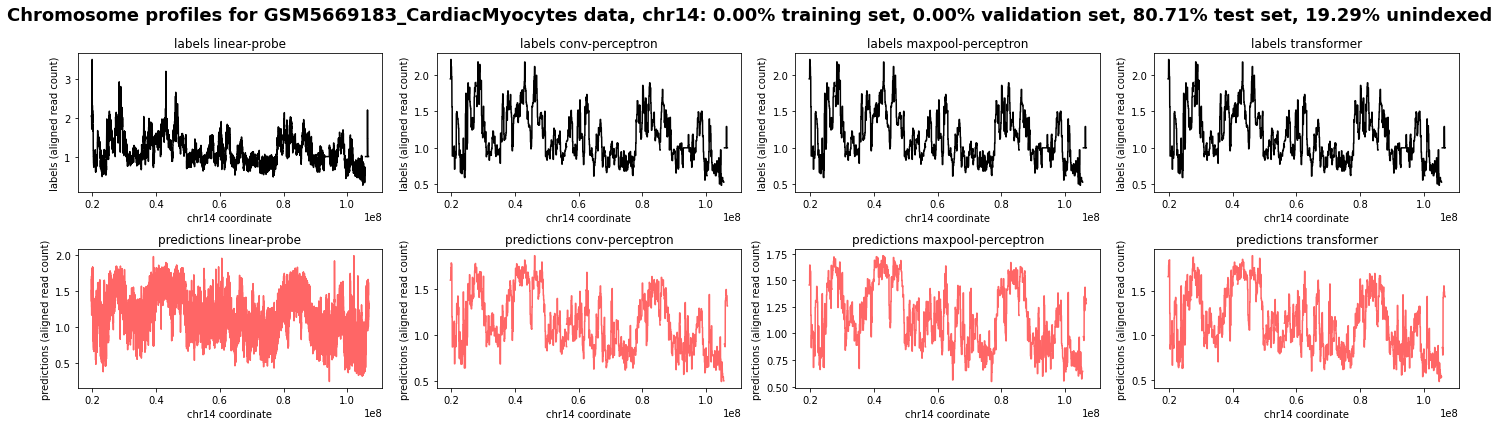

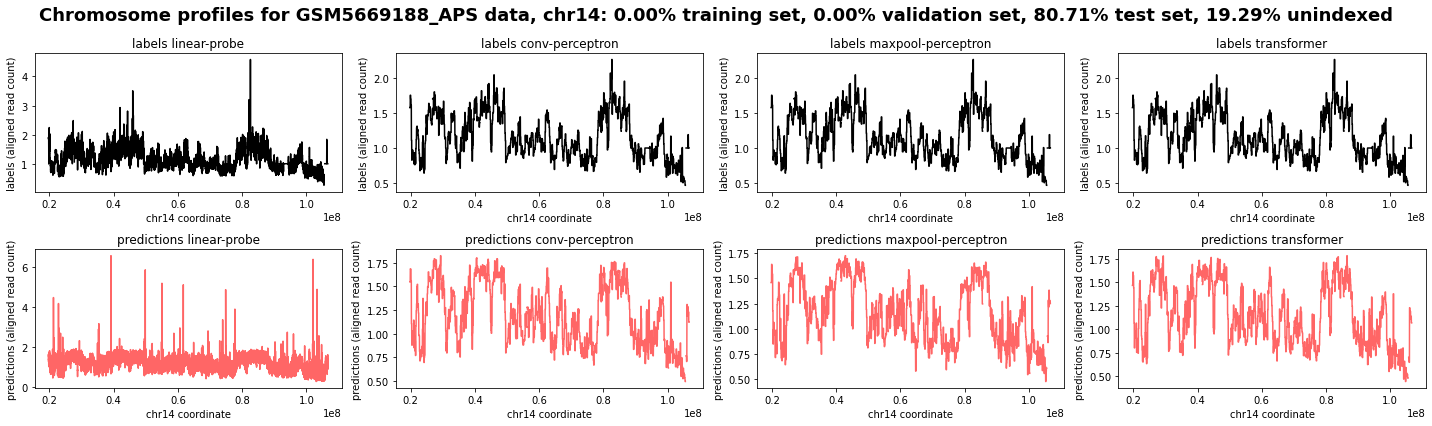

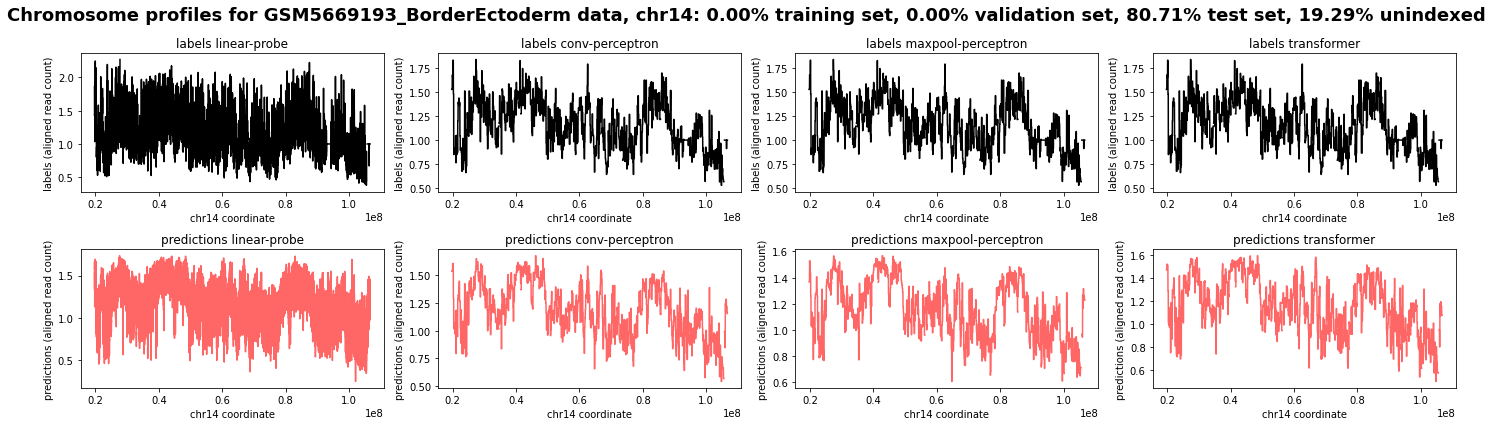

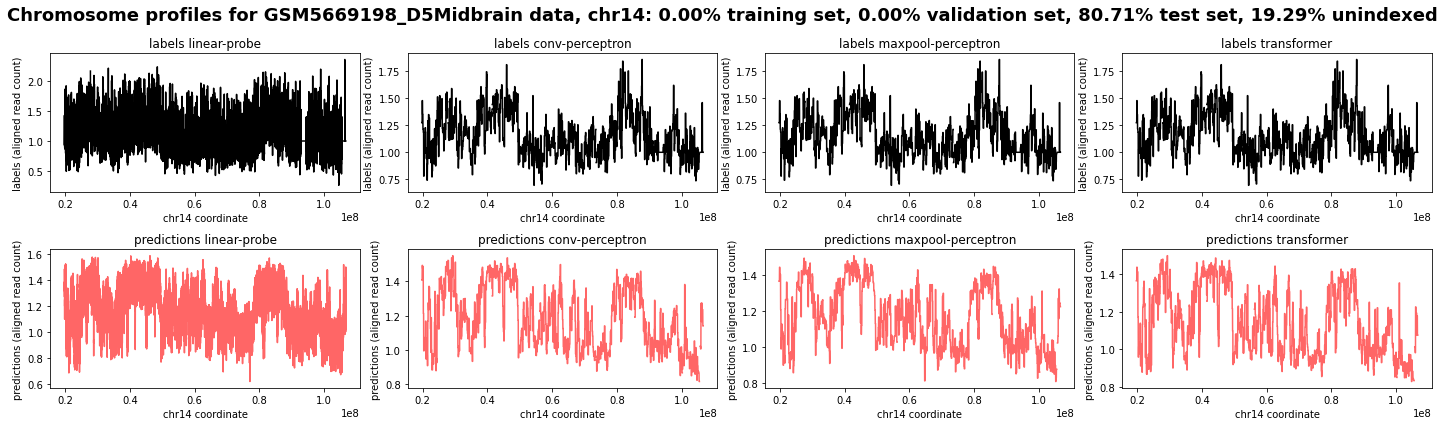

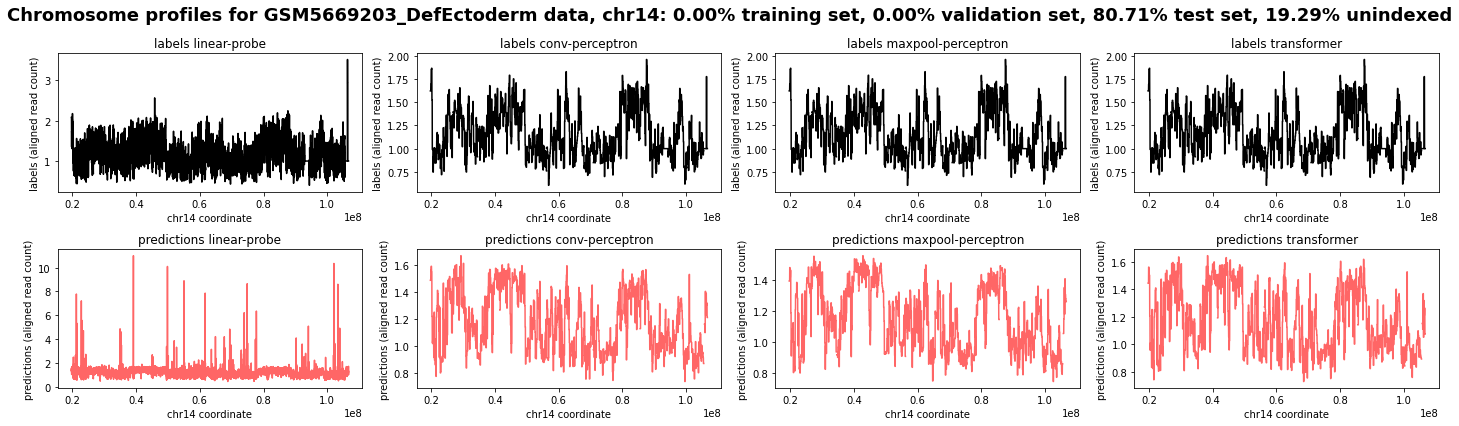

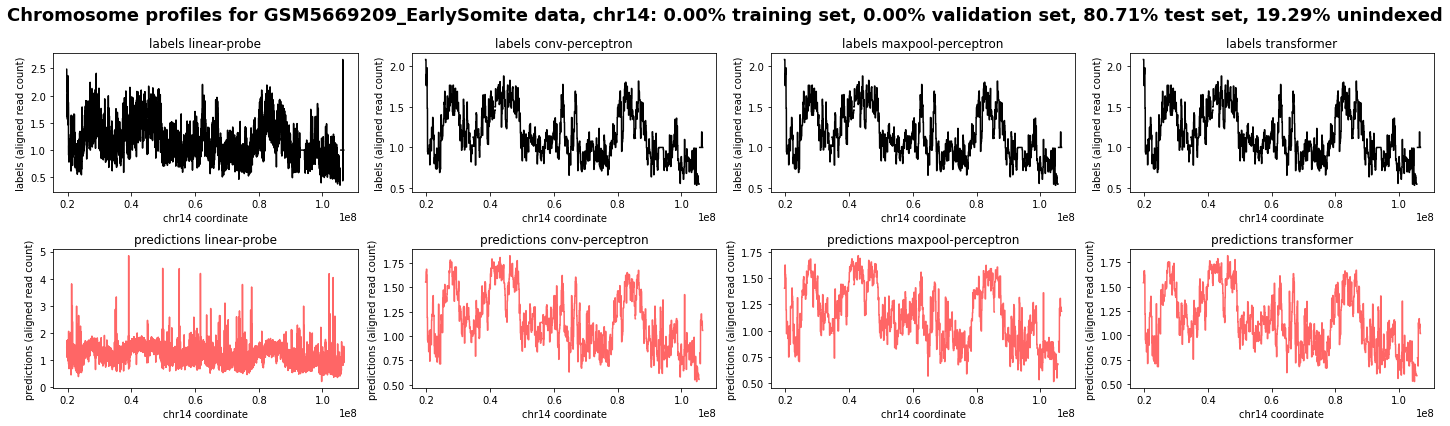

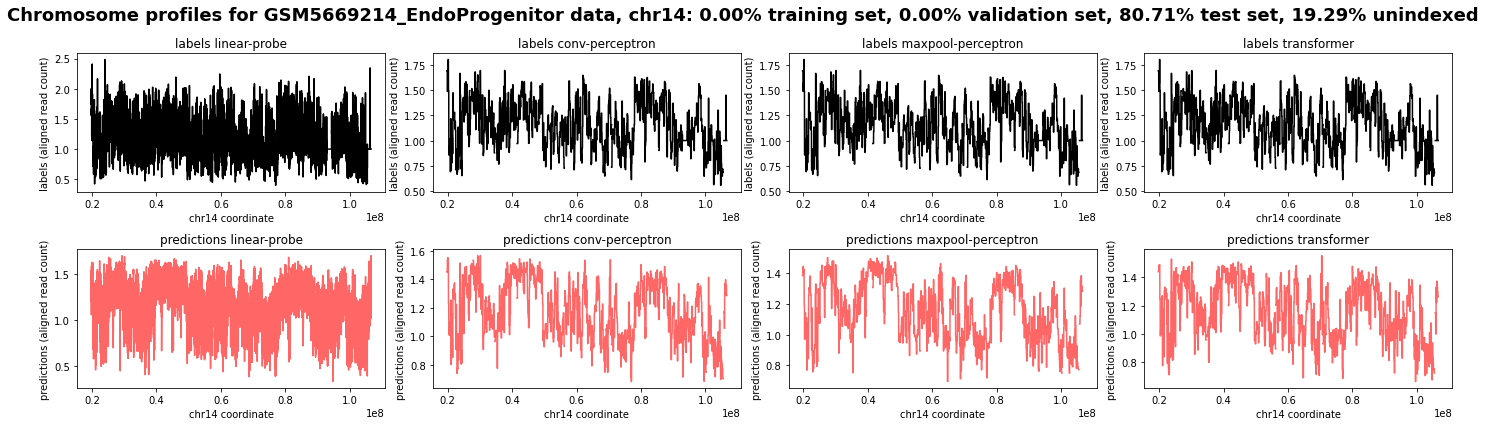

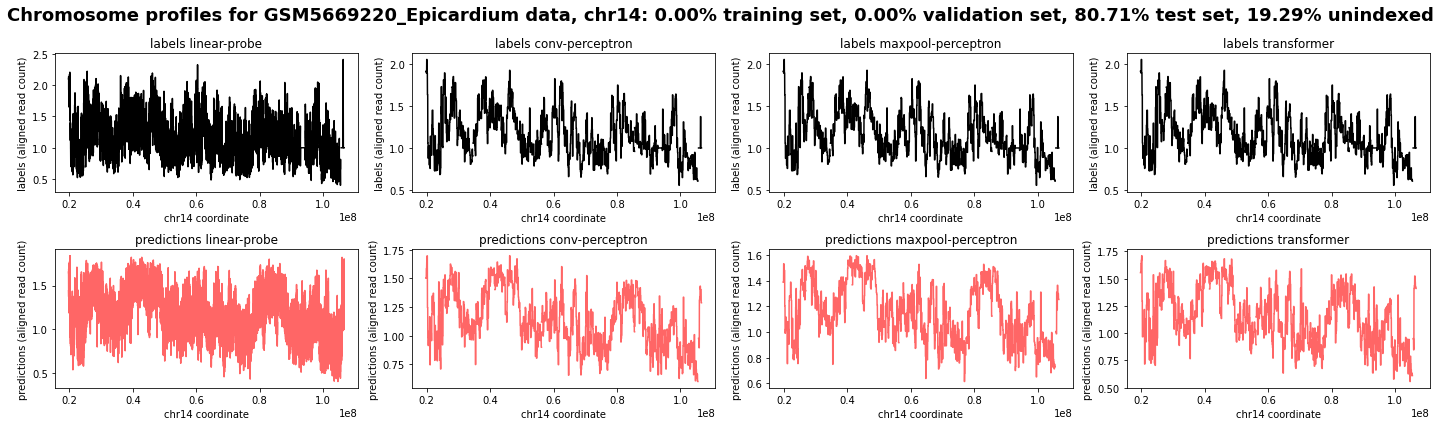

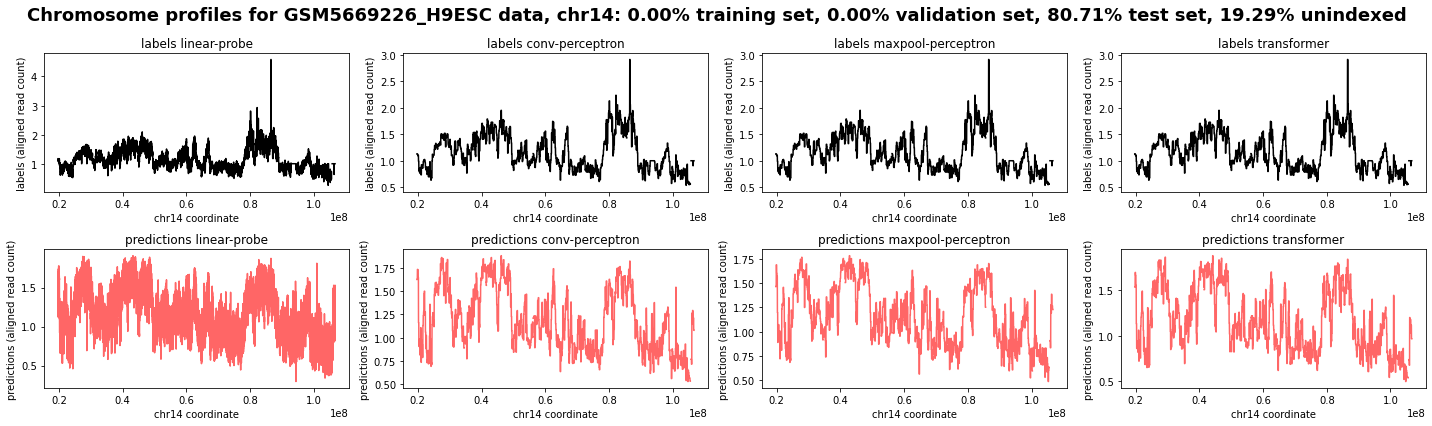

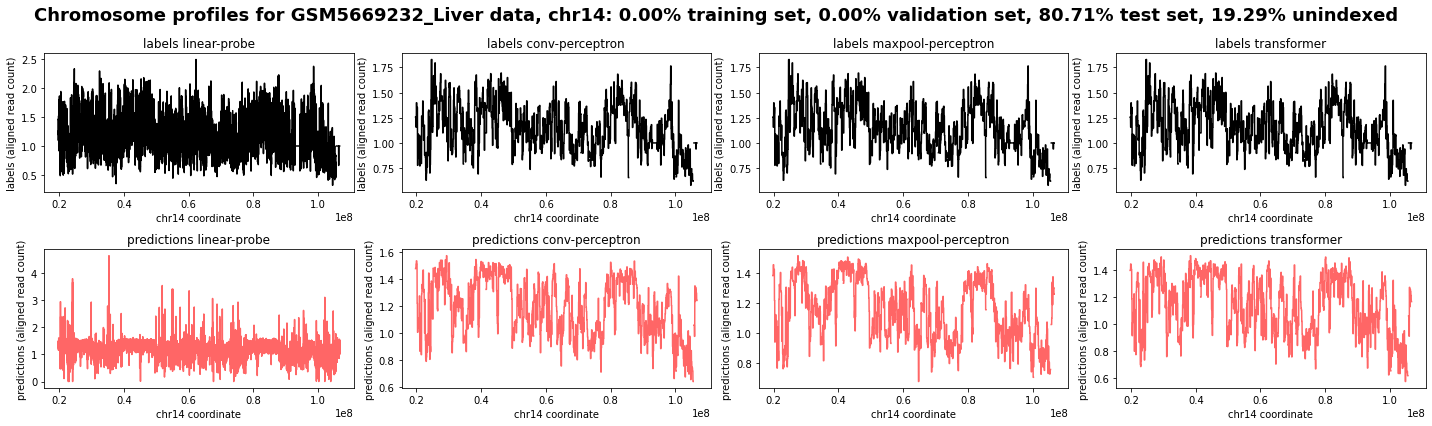

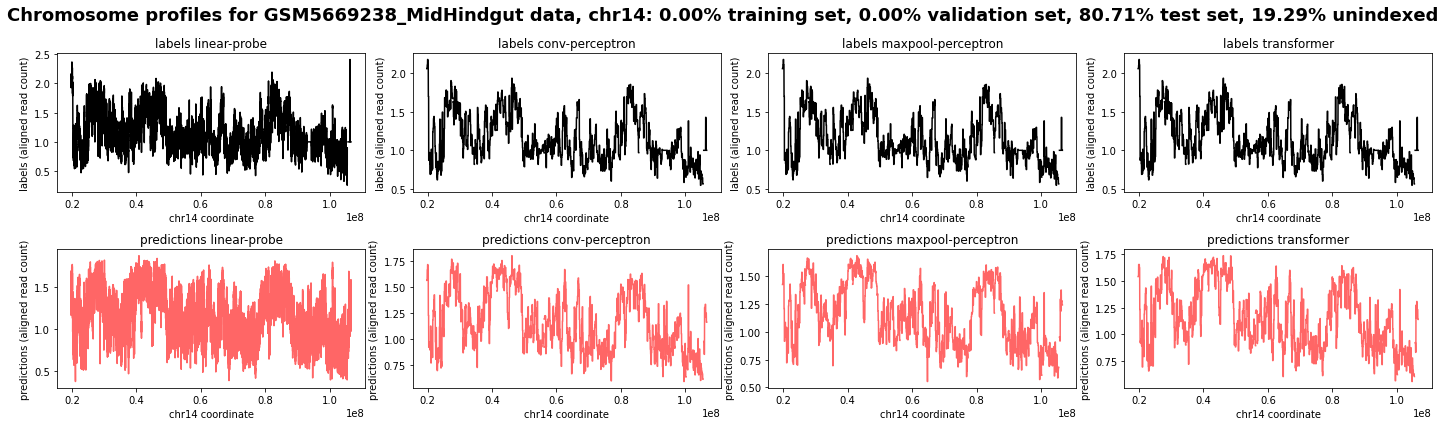

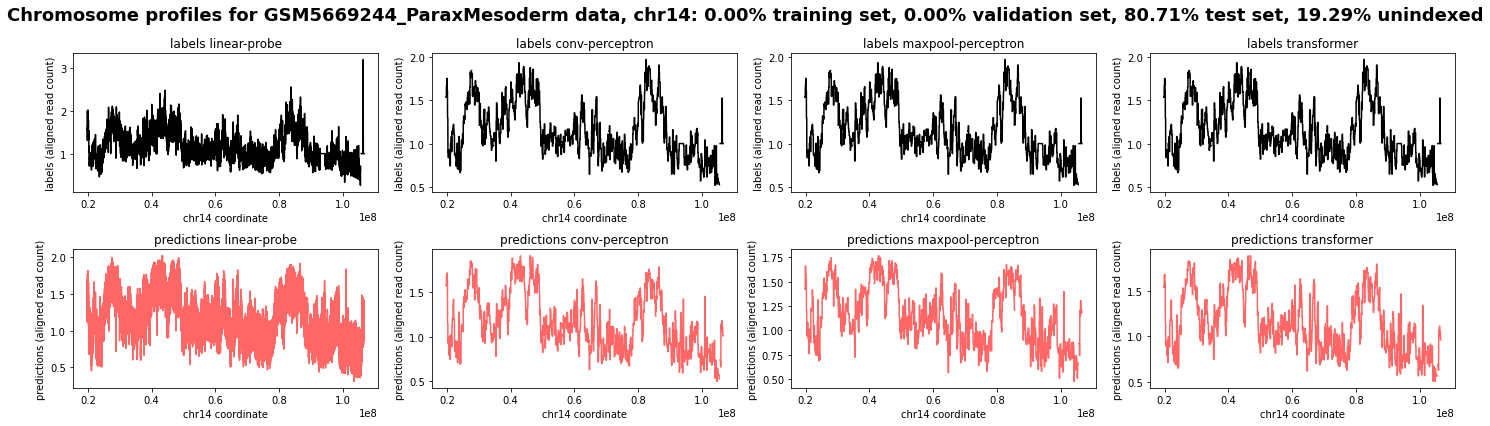

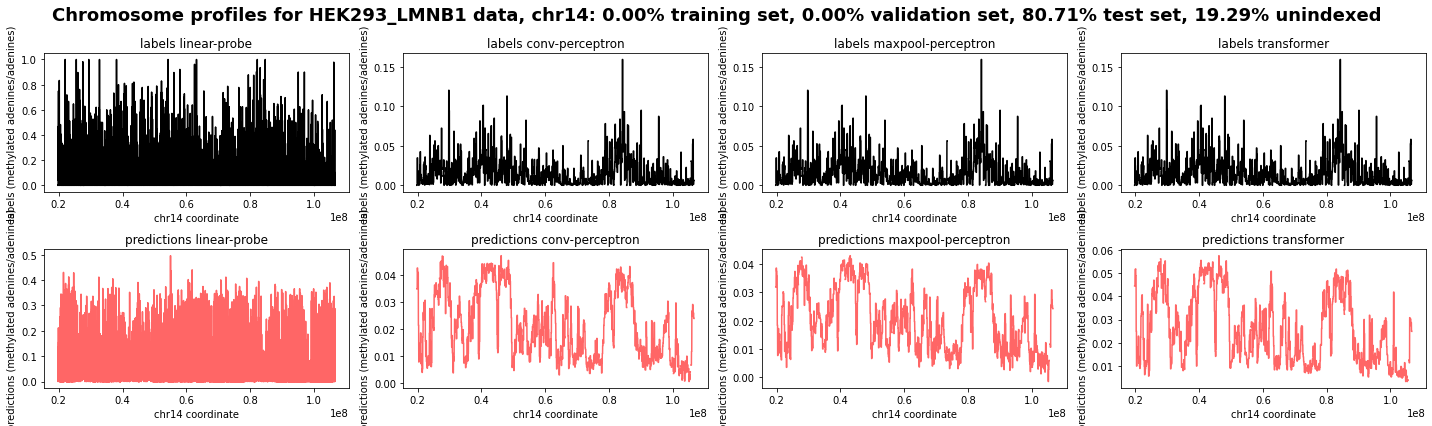

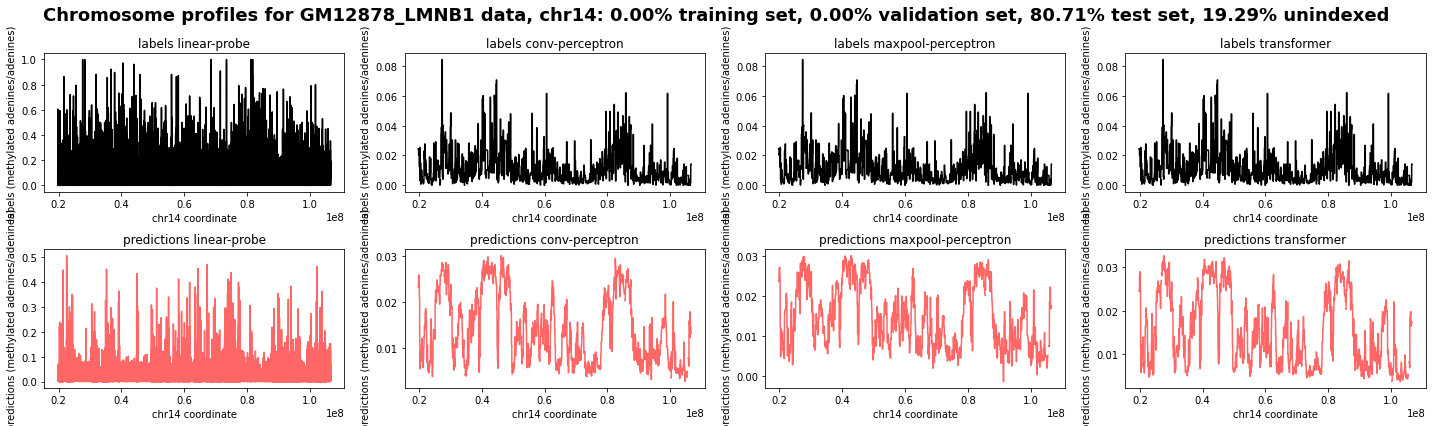

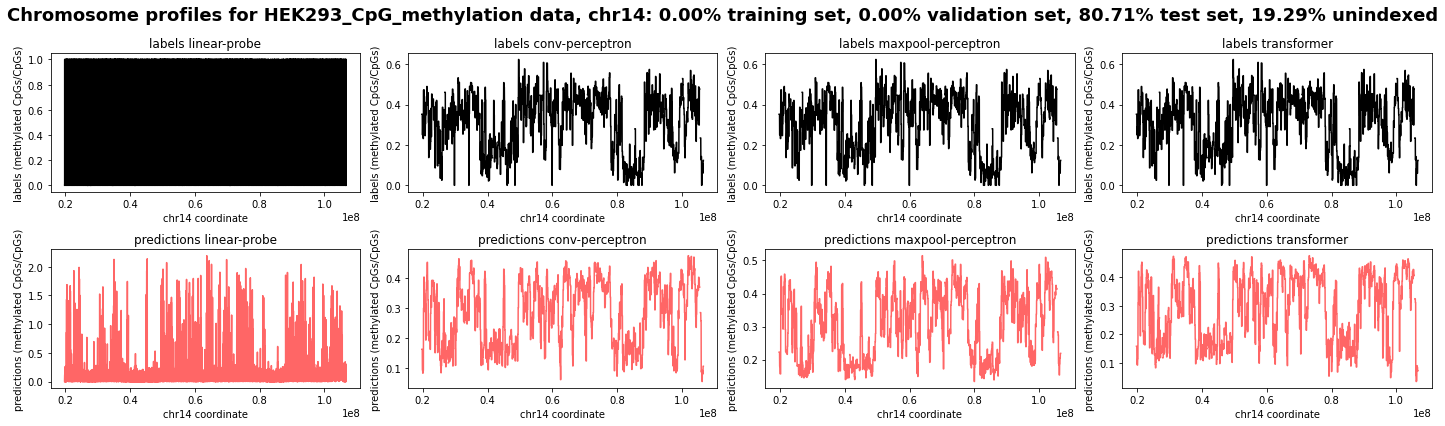

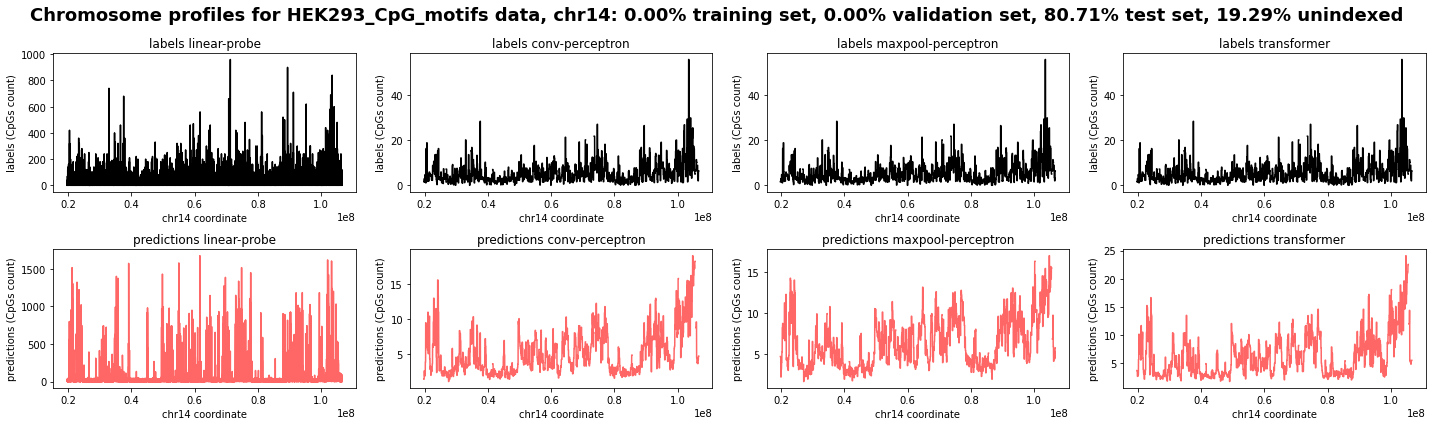

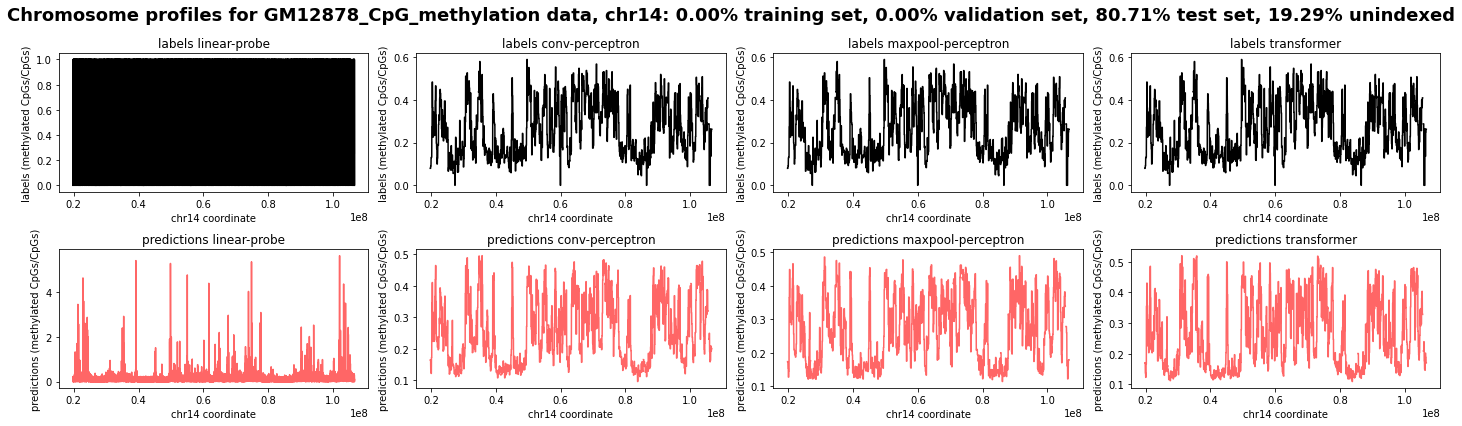

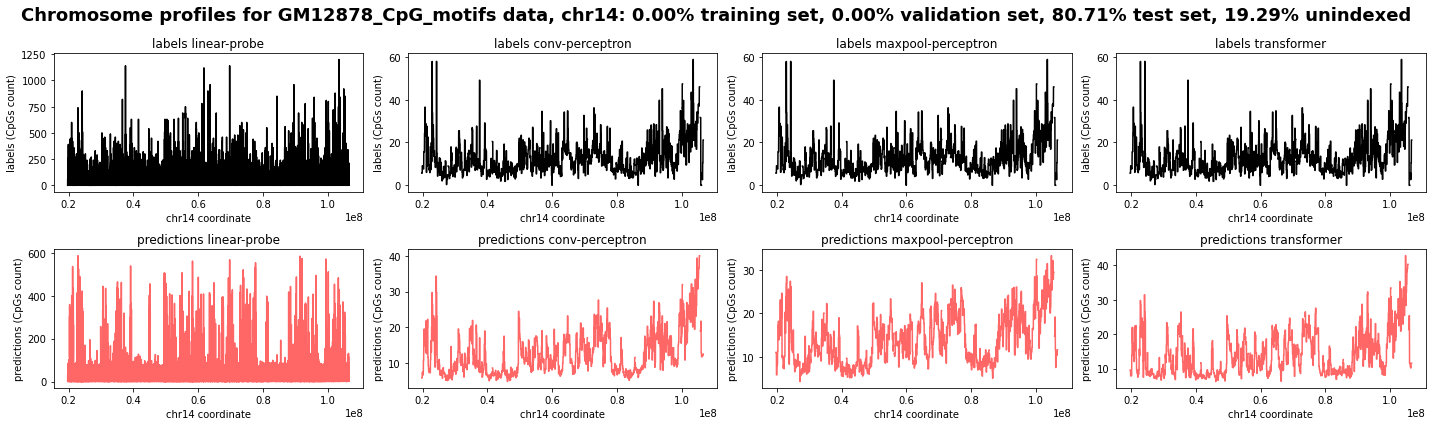

In [20]:
colors = {0: '1.0', 1: '0.9', 2: '0.75', 3: '0.5'}
def apply_fill_between(ax, x_coords, y_data, split_array, colors):
    start_idx = 0
    for i in range(1, len(split_array)):
        if split_array[i] != split_array[start_idx]:
            ax.fill_between(x=x_coords[start_idx:i], y1=y_data[start_idx:i], color=colors[split_array[start_idx]])
            start_idx = i
    
    ax.fill_between(x_coords[start_idx:], y_data[start_idx:], color=colors[split_array[start_idx]])


for plot_chrom in plot_chroms:
    (
    plot_xcoord,
    plot_array_low_res,
    plot_array_high_res,
    output_arrays,
    cm_lads_array,
    fl_lads_array,
    test_train_split_array,
    ) = chrom_results[plot_chrom]
    for i,track_name in enumerate(all_tracks):
        scaling = scaling_by_track[i]
        axlabel = data_label_by_track[i]
        fig1, axs1 = plt.subplots(2,4,figsize=(20,6))
        fig1.suptitle(f'Chromosome profiles for {track_name} data, {plot_chrom}: {sets_strings_dict[plot_chrom]}',fontweight='bold',size=18)
        for idx,(key,output_array) in enumerate(output_arrays.items()):
            if h5_files_dict[key][1]=='128bp_bins':
                axs1[0,idx].plot(plot_xcoord,plot_array_high_res[:,i]*scaling,'k',label='128bp bin labels')  
                axs1[1,idx].plot(plot_xcoord,output_array[:,i]*scaling,'r-',alpha=0.6,label='128bp bin predictions')
            elif h5_files_dict[key][1]=='single_bin':
                axs1[0,idx].plot(plot_xcoord,plot_array_low_res[:,i]*scaling,'k',label='114kbp bin labels')
                axs1[1,idx].plot(plot_xcoord,output_array[:,i]*scaling,'r-',alpha=0.6,label='114kbp bin predictions')
            axs1[0,idx].set_title(f'labels {key}')
            axs1[1,idx].set_title(f'predictions {key}')
            axs1[0,idx].set_ylabel(f'labels {axlabel}')
            axs1[1,idx].set_ylabel(f'predictions {axlabel}')
            axs1[0,idx].set_xlabel(f'{plot_chrom} coordinate')
            axs1[1,idx].set_xlabel(f'{plot_chrom} coordinate')
#             axs1[idx].legend(loc="upper center")
        plt.tight_layout()
        plt.show()

In [21]:
import pandas as pd
from pybedtools import BedTool
hg38_genome_path = '/clusterfs/nilah/ayesha/basenji/baselines/gm12878/data/hg38.fa'
hg38_fasta = pysam.FastaFile(hg38_genome_path)
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/0.5/manuscripts/cross2020/targets_human.txt'
targets_df = pd.read_csv(targets_txt, sep='\t')
targets_df.shape  # (5313, 8) With rows match output shape above.
search_terms_hek_cage = ['HEK293','CAGE']
search_terms_cm_cage = ['Cardiac Myocyte','CAGE']
search_terms_liver_cage = ['liver, fetal','CAGE']
regex_hek_cage = '(?=.*{})'.format(')(?=.*'.join(search_terms_hek_cage))
regex_cm_cage = '(?=.*{})'.format(')(?=.*'.join(search_terms_cm_cage))
regex_liver_cage = '(?=.*{})'.format(')(?=.*'.join(search_terms_liver_cage))
target_indices_hek_cage = targets_df[targets_df['description'].str.contains(regex_hek_cage,case=False)].index
target_indices_cm_cage = targets_df[targets_df['description'].str.contains(regex_cm_cage,case=False)].index
target_indices_liver_cage = targets_df[targets_df['description'].str.contains(regex_liver_cage,case=False)].index
target_indices_all_cage = targets_df[targets_df['description'].str.contains('CAGE',case=False)].index
gtf = BedTool('/clusterfs/nilah/oberon/datasets/gencode/gencode.v44.annotation.gtf')
tss_dict = defaultdict(list)
for f in tqdm(gtf):
    if f[2]=='gene':
        if f[6]=='+':
            tss_dict[f[0]].append((f[8],int(f[3])))
        elif f[6]=='-':
            tss_dict[f[0]].append((f[8],int(f[4])))

  0%|          | 0/3424189 [00:00<?, ?it/s]

In [22]:
import re
print(target_indices_cm_cage,target_indices_hek_cage[0:1])
inferences_prefix = '/clusterfs/nilah/oberon/datasets/basenji_outputs/hdf5/cage_track_predictions_'
records_prefix = '/clusterfs/nilah/oberon/datasets/basenji/cage/tfrs_seq-targets_basenji_test-train-valid_CAGE_'
cm_cage_meas = []
cm_cage_infer = []
hek_cage_meas = []
hek_cage_infer = []
lamin_meas = []
lamin_infer = []
cm_lads = []
cpg_meas = []
cpg_infer = []
transcript_type = []
cage_bins = 0
state_bins = 16
for chromosome in tqdm(plot_chroms):
    with h5py.File(f'{inferences_prefix}{chromosome}.h5') as inferences, \
    h5py.File(f'{records_prefix}{chromosome}.h5') as records:
        record_indices = np.array(records[f'{chromosome}/target_indices'][:])
        target_indices_relative = np.where(np.isin(record_indices,
                                                   np.concatenate([target_indices_cm_cage,
                                                                   target_indices_hek_cage[0:1]])))[0]
        for gene_obj in tqdm(tss_dict[chromosome]):
            center_coord = gene_obj[1]
            try:
                measurement_array = records[f'{chromosome}/targets'][center_coord//128-(cage_bins//2):(center_coord-1)//128+2+(cage_bins//2),target_indices_relative]
                inference_array = inferences[f'{chromosome}/targets'][center_coord//128-(cage_bins//2):(center_coord-1)//128+2+(cage_bins//2),target_indices_relative]
            except OSError as e:
                print(f'error in {chromosome}:{center_coord}')
                measurement_array = np.zeros(len(target_indices_relative))
                inference_array = np.zeros(len(target_indices_relative))
                continue
            lamina_meas_array = (chrom_results[plot_chrom][1][center_coord//128-(state_bins//2):(center_coord-1)//128+2+(state_bins//2),0])
            lamina_pred_array = (chrom_results[plot_chrom][3]['conv-perceptron'][center_coord//128+(state_bins//2):(center_coord-1)//128+2+(state_bins//2),0])
            hekcpg_meas_array = (chrom_results[plot_chrom][1][center_coord//128-(state_bins//2):(center_coord-1)//128+2+(state_bins//2),14])
            hekcpg_pred_array = (chrom_results[plot_chrom][3]['conv-perceptron'][center_coord//128+(state_bins//2):(center_coord-1)//128+2+(state_bins//2),14])
            transcript_type.append(re.search('gene_type "([^"]+)"', gene_obj[0]).group(1))
#             print((measurement_array))
            
#             print(hekcpg_meas_array.shape)
            cm_cage_meas.append(np.mean(measurement_array[:,0]))
            cm_cage_infer.append(np.mean(inference_array[:,0]))
            cm_lads.append(np.nanmean(chrom_results[plot_chrom][4][center_coord//128:center_coord//128+1]))
            hek_cage_meas.append(np.mean(measurement_array[:,1]))
            hek_cage_infer.append(np.mean(inference_array[:,1]))
            lamin_meas.append(np.nanmean(lamina_meas_array))
            lamin_infer.append(np.nanmean(lamina_pred_array))
            cpg_meas.append(np.nanmean(hekcpg_meas_array))
            cpg_infer.append(np.nanmean(hekcpg_pred_array))

Int64Index([5115], dtype='int64') Int64Index([4789], dtype='int64')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2341 [00:00<?, ?it/s]

/tmp/ipykernel_258908/2812035007.py:47: RuntimeWarning: Mean of empty slice
  lamin_meas.append(np.nanmean(lamina_meas_array))
/tmp/ipykernel_258908/2812035007.py:48: RuntimeWarning: Mean of empty slice
  lamin_infer.append(np.nanmean(lamina_pred_array))
/tmp/ipykernel_258908/2812035007.py:49: RuntimeWarning: Mean of empty slice
  cpg_meas.append(np.nanmean(hekcpg_meas_array))
/tmp/ipykernel_258908/2812035007.py:50: RuntimeWarning: Mean of empty slice
  cpg_infer.append(np.nanmean(hekcpg_pred_array))


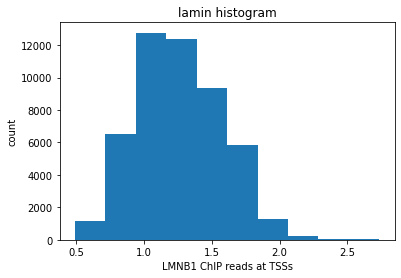

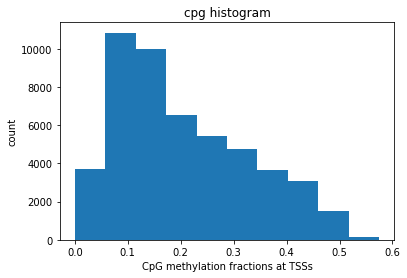

[0.   0.16 0.32 0.44 0.49 0.5 ] [35264 16398  7828  1895   396   281]


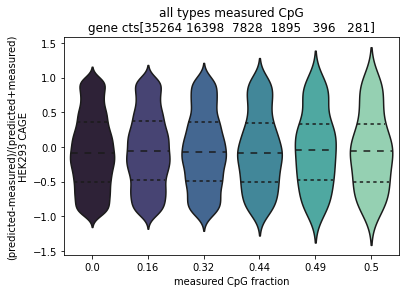

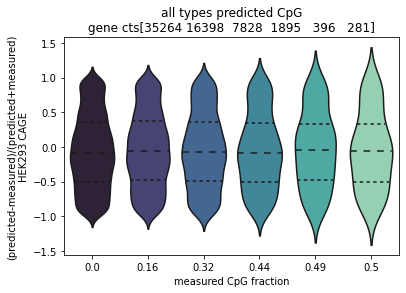

[0.  1.6 1.8 1.9 2. ] [54073  5694  1511   459   325]


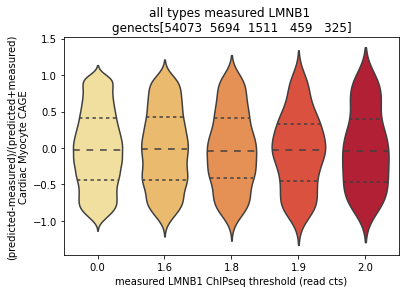

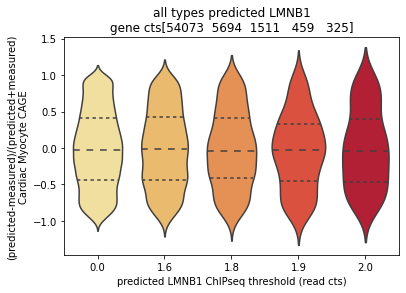

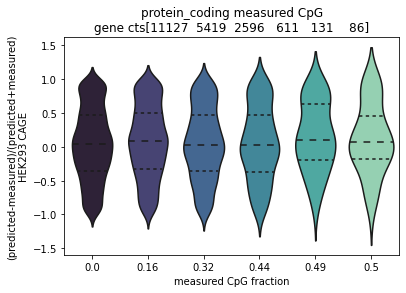

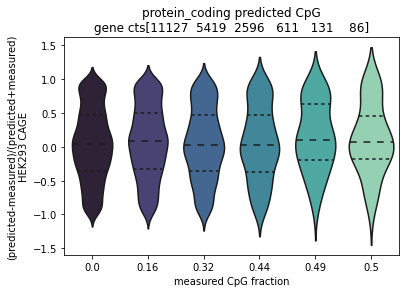

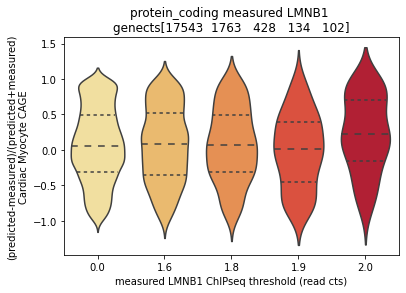

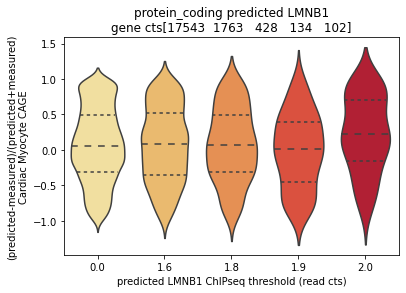

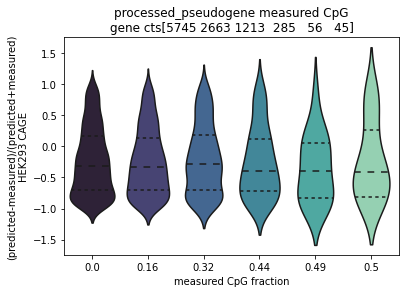

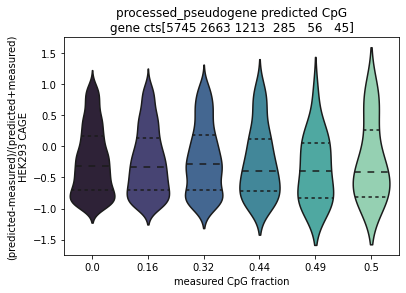

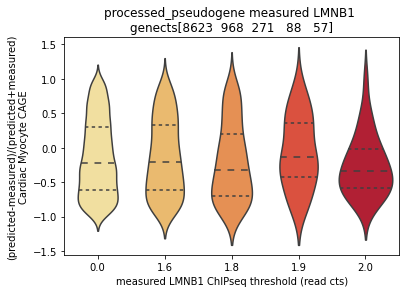

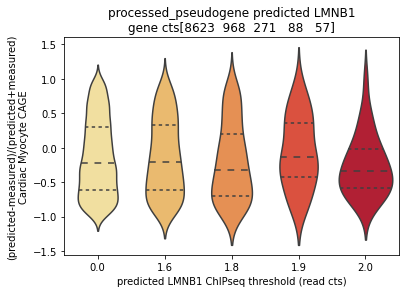

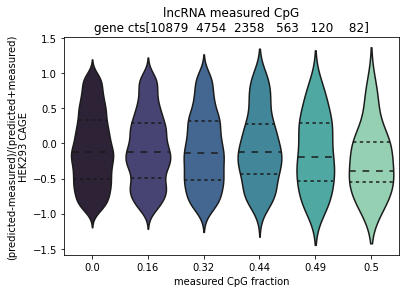

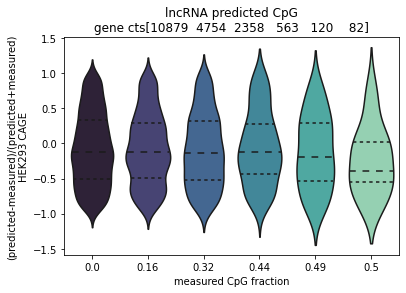

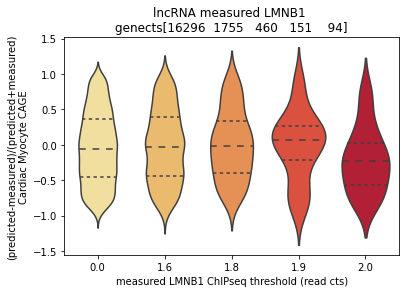

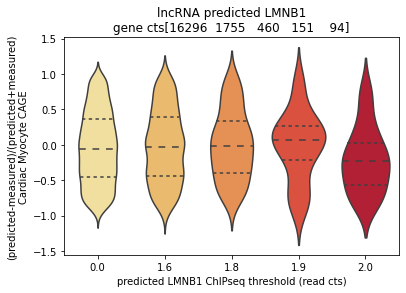

In [61]:
import seaborn as sns
cm_cage_meas_array = np.array(cm_cage_meas)
cm_cage_pred_array = np.array(cm_cage_infer)
cm_lads_array = np.array(cm_lads)
hek_cage_meas_array = np.array(hek_cage_meas)
hek_cage_pred_array = np.array(hek_cage_infer)
lamin_meas_array = np.array(lamin_meas)
lamin_pred_array = np.array(lamin_infer)
cpg_meas_array = np.array(cpg_meas)
cpg_pred_array = np.array(cpg_infer)
transcript_types_array = np.array(transcript_type)

# plt.hist(cm_lads_array)
# plt.xlabel('LAD category at TSSs')
# plt.ylabel('count')
# plt.show('LAD histogram')
# plt.show()

plt.hist(lamin_meas_array/128)
plt.xlabel('LMNB1 ChIP reads at TSSs')
plt.ylabel('count')
plt.title('lamin histogram')
plt.show()

meas_zeromask = cm_cage_meas_array>0
hek_meas_zeromask = hek_cage_meas_array>0
lamin_meas_bound = np.zeros(lamin_meas_array.shape)
lamin_pred_bound = np.zeros(lamin_pred_array.shape)
for thresh in [204.8,230.4,243.2,256]:
    lamin_meas_bound[lamin_meas_array>thresh]=thresh/128
    lamin_pred_bound[lamin_meas_array>thresh]=thresh/128
    
cpg_meas_bound = np.zeros(cpg_meas_array.shape)
cpg_pred_bound = np.zeros(cpg_pred_array.shape)    
for thresh in [80,160,220,245,250]:
    cpg_meas_bound[cpg_meas_array>thresh]=thresh/500
    cpg_pred_bound[cpg_meas_array>thresh]=thresh/500   
    
plt.hist(cpg_meas_array/500)
plt.xlabel('CpG methylation fractions at TSSs')
plt.ylabel('count')
plt.title('cpg histogram')
plt.show()    
values,counts = np.unique(cpg_pred_bound,return_counts=True)
print(values,counts)
    
sns.violinplot(x=cpg_meas_bound[hek_meas_zeromask],
               y=((hek_cage_pred_array-hek_cage_meas_array)/(hek_cage_pred_array+hek_cage_meas_array))[hek_meas_zeromask],
               inner='quartile',
               palette='mako')
plt.xlabel('measured CpG fraction')
plt.ylabel('(predicted-measured)/(predicted+measured)\nHEK293 CAGE')
plt.title('all types measured CpG\ngene cts'+str(counts))
plt.show()

sns.violinplot(x=cpg_pred_bound[hek_meas_zeromask],
               y=((hek_cage_pred_array-hek_cage_meas_array)/(hek_cage_pred_array+hek_cage_meas_array))[hek_meas_zeromask],
               inner='quartile',
               palette='mako')
plt.xlabel('measured CpG fraction')
plt.ylabel('(predicted-measured)/(predicted+measured)\nHEK293 CAGE')
plt.title('all types predicted CpG\ngene cts'+str(counts))
plt.show()

values,counts = np.unique(lamin_pred_bound,return_counts=True)
print(values,counts)

sns.violinplot(x=lamin_meas_bound[meas_zeromask],y=((cm_cage_pred_array-cm_cage_meas_array)/(cm_cage_pred_array+cm_cage_meas_array))[meas_zeromask],inner='quartile',palette='YlOrRd')
plt.xlabel('measured LMNB1 ChIPseq threshold (read cts)')
plt.ylabel('(predicted-measured)/(predicted+measured)\nCardiac Myocyte CAGE')
plt.title('all types measured LMNB1 \ngenects'+str(counts))
plt.show()
sns.violinplot(x=lamin_pred_bound[meas_zeromask],y=((cm_cage_pred_array-cm_cage_meas_array)/(cm_cage_pred_array+cm_cage_meas_array))[meas_zeromask],inner='quartile',palette='YlOrRd')
plt.xlabel('predicted LMNB1 ChIPseq threshold (read cts)')
plt.ylabel('(predicted-measured)/(predicted+measured)\nCardiac Myocyte CAGE')
plt.title('all types predicted LMNB1\ngene cts'+str(counts))
plt.show()

# sns.violinplot(x=cm_lads_array[meas_zeromask],y=((cm_cage_pred_array-cm_cage_meas_array)/(cm_cage_pred_array+cm_cage_meas_array))[meas_zeromask],inner='quartile',palette='YlOrRd')
# plt.xlabel('LAD category')
# plt.ylabel('(predicted-measured)/(predicted+measured)\nCardiac Myocyte CAGE')
# plt.title('all transcripts by LAD type\ngene cts'+str(counts))
# plt.show()


for trans_type in ['protein_coding','processed_pseudogene','lncRNA']:
    typemask = (transcript_types_array==trans_type)
    values,counts = np.unique(cpg_meas_bound[typemask],return_counts=True)
    sns.violinplot(x=cpg_meas_bound[hek_meas_zeromask & typemask],
                   y=((hek_cage_pred_array-hek_cage_meas_array)/(hek_cage_pred_array+hek_cage_meas_array))[hek_meas_zeromask & typemask],
                   inner='quartile',
                   palette='mako')
    plt.xlabel('measured CpG fraction')
    plt.ylabel('(predicted-measured)/(predicted+measured)\nHEK293 CAGE')
    plt.title(trans_type+' measured CpG\ngene cts'+str(counts))
    plt.show()

    sns.violinplot(x=cpg_pred_bound[hek_meas_zeromask & typemask],
                   y=((hek_cage_pred_array-hek_cage_meas_array)/(hek_cage_pred_array+hek_cage_meas_array))[hek_meas_zeromask & typemask],
                   inner='quartile',
                   palette='mako')
    plt.xlabel('measured CpG fraction')
    plt.ylabel('(predicted-measured)/(predicted+measured)\nHEK293 CAGE')
    plt.title(trans_type+' predicted CpG\ngene cts'+str(counts))
    plt.show()    
    
    values,counts = np.unique(lamin_meas_bound[typemask],return_counts=True)
    sns.violinplot(x=lamin_meas_bound[meas_zeromask & typemask],y=((cm_cage_pred_array-cm_cage_meas_array)/(cm_cage_pred_array+cm_cage_meas_array))[meas_zeromask & typemask],inner='quartile',palette='YlOrRd')
    plt.xlabel('measured LMNB1 ChIPseq threshold (read cts)')
    plt.ylabel('(predicted-measured)/(predicted+measured)\nCardiac Myocyte CAGE')
    plt.title(trans_type+' measured LMNB1 \ngenects'+str(counts))
    plt.show()
    sns.violinplot(x=lamin_pred_bound[meas_zeromask & typemask],y=((cm_cage_pred_array-cm_cage_meas_array)/(cm_cage_pred_array+cm_cage_meas_array))[meas_zeromask & typemask],inner='quartile',palette='YlOrRd')
    plt.xlabel('predicted LMNB1 ChIPseq threshold (read cts)')
    plt.ylabel('(predicted-measured)/(predicted+measured)\nCardiac Myocyte CAGE')
    plt.title(trans_type+' predicted LMNB1\ngene cts'+str(counts))
    plt.show()